In this notebook, I will compare several binary classification models using a simulated dataset.

The data is simulated using scikit-learn's ```make_classification```. First, the models will be trained and tested on a simple dataset with 2 relevant features. Later, they will be trained and tested on a more complex dataset with both redundant and repeated features without any feature engineering. ```make_classification``` documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

I will try the following scikit-learn classifiers (click on the model name for documentation): [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html),
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html),
[LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html),
[KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html),
[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

I will also add multiplayer perceptrons in Keras and PyTorch and evaluate their performances.

Let's create a dataframe to store accuracies of the classifier for comparison later.

In [1]:
import pandas as pd

accuracy_df = pd.DataFrame(columns = ['Dataset 1', 'Dataset 2', 'Dataset 3', 
                                      'Dataset 4', 'Dataset 5'])

In [2]:
# create simulated data with 2 features
from sklearn.datasets import make_classification

X, Y = make_classification(n_samples = 1000,
                           n_features = 2,
                           n_informative = 2,
                           n_redundant = 0,
                           n_clusters_per_class = 1,
                           random_state = 47)

In [3]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 47)

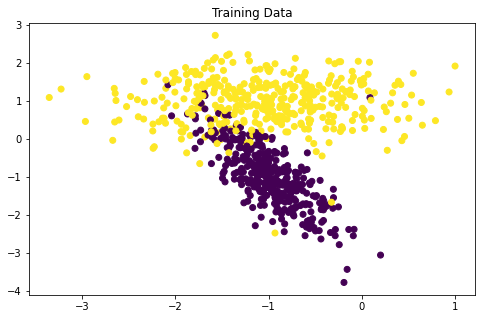

In [4]:
# plot the training data
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], X_train[:,1], c = Y_train)
plt.title('Training Data')
plt.show()

In [5]:
# import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [6]:
# initialize scikit-learn classifiers with mostly default values
log_reg = LogisticRegression()
dt_clf = DecisionTreeClassifier()
# initialize Linear SVC with max_iter = 10000 to ensure convergence
linear_svc = LinearSVC(max_iter = 10000)
kn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()


clf_list = [log_reg, dt_clf, linear_svc, kn_clf, rf_clf, gb_clf]

clf_names = ['Logistic Regression', 'Decision Tree Classifier', 'Linear SVC',
            'KNN Classifier', 'Random Forest Classifier', 'Gradient Boosting Classfier']

In [7]:
# define a function that will take in training and testing data,
# and then will fit the classifiers and score their predictions

def scikit_clf_fit_score(x_train, y_train, x_test, y_test, dataset_num):
    
    # loop over each classifier in clf_list, fit, score, add score to accuracy_df
    dataset = f'Dataset {dataset_num}'
    
    for i in range(6):
        clf_list[i].fit(x_train, y_train)
        score = clf_list[i].score(x_test, y_test)
        accuracy_df.loc[clf_names[i], dataset] = score
        print(f'{clf_names[i]}: {score}')

In [8]:
%%time
scikit_clf_fit_score(X_train, Y_train, X_test, Y_test, 1)

Logistic Regression: 0.928
Decision Tree Classifier: 0.94
Linear SVC: 0.928
KNN Classifier: 0.952
Random Forest Classifier: 0.952
Gradient Boosting Classfier: 0.952
Wall time: 499 ms


In [9]:
# create a function that fits and evaluates a binary classification model in Keras
from keras.models import Sequential
from keras.layers import Dense

def keras_nn_fit_score(x_train, y_train, x_test, y_test, dataset_num, n_epochs = 50):
    
    dataset = f'Dataset {dataset_num}'
    
    # three layer model with ReLU applied to the first two layers
    # and sigmoid to the last one
    model = Sequential([
    Dense(30, input_shape=(x_train.shape[1],), activation = 'relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')])
    
    # compile the model using binary crossentropy as the loss function and
    # binary accuracy as the evaluation metric
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    model.fit(x_train, y_train, epochs = n_epochs)
    
    # evaluate using the test data
    results = model.evaluate(x_test, y_test)
    accuracy_df.loc['Keras NN', dataset] = float(f'{results[1]:.3}')
    print(results)

In [10]:
%%time
keras_nn_fit_score(X_train, Y_train, X_test, Y_test, 1)

Epoch 1/50
24/24 [==============================] - 0s 1ms/step - loss: 0.6071 - binary_accuracy: 0.8413
Epoch 2/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4688 - binary_accuracy: 0.8973
Epoch 3/50
24/24 [==============================] - 0s 956us/step - loss: 0.3493 - binary_accuracy: 0.9147
Epoch 4/50
24/24 [==============================] - 0s 574us/step - loss: 0.2698 - binary_accuracy: 0.9307
Epoch 5/50
24/24 [==============================] - 0s 973us/step - loss: 0.2304 - binary_accuracy: 0.9307
Epoch 6/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2142 - binary_accuracy: 0.9320
Epoch 7/50
24/24 [==============================] - 0s 997us/step - loss: 0.2073 - binary_accuracy: 0.9293
Epoch 8/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2020 - binary_accuracy: 0.9267
Epoch 9/50
24/24 [==============================] - 0s 5ms/step - loss: 0.2007 - binary_accuracy: 0.9360
Epoch 10/50
24/24 [============================

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# BCELoss will be used for all neural networks
criterion = nn.BCELoss()

In [12]:
# create a binary classification model in PyTorch
# the NN will be the same except for the number of input nodes for all datasets

class TorchBinaryClassifier(nn.Module):
    
    def __init__(self, in_dimension):
        
        super(TorchBinaryClassifier, self).__init__()
        
        # 3 layer NN similar to the one done in Keras
        self.fc1 = nn.Linear(in_dimension, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 1)
        
        # sigmoid layer for classification
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
        # apply ReLU after each of the first two layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # apply sigmoid function before returning the value
        x = self.sig(x)
        
        return x

In [13]:
# speficy train and test data
from torch.utils.data import TensorDataset, DataLoader

# set up a function to get dataloaders
def pytorch_loaders(x_train, y_train, x_test, y_test):
    
    X_train_tensor = torch.from_numpy(x_train).float()
    Y_train_tensor = torch.from_numpy(y_train).float().squeeze()

    X_test_tensor = torch.from_numpy(x_test).float()
    Y_test_tensor = torch.from_numpy(y_test).float()

    trainset = TensorDataset(X_train_tensor, Y_train_tensor)
    testset = TensorDataset(X_test_tensor, Y_test_tensor)

    train_loader = DataLoader(trainset)
    test_loader = DataLoader(testset)
    
    return train_loader, test_loader

In [14]:
# set up a training function
def pytorch_train(model, train_loader, n_epochs = 50):
    
    # define the optimizer
    optimizer = optim.Adam(model.parameters())
    
    # set model to train mode
    model.train()
    print('PyTorch model training...')
    
    for epoch in range(n_epochs):
        # zero the running loss for the epoch
        running_loss = 0.0
        
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1,1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print(f'Epoch: {epoch + 1}, training loss: {running_loss/len(train_loader.dataset)}')

In [15]:
import numpy as np

# set up a testing function
def pytorch_test(model, test_loader):
    # set model in evaluation mode
    model.eval()
    print('PyTorch model testing...')
    
    test_loss = 0.0
    correct_predictions = 0
    
    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target.view(-1,1))
        test_loss += loss.item()
        predicted = np.round(output.detach().numpy().squeeze())
        actual = target.numpy().squeeze()
        
        if predicted == actual:
            correct_predictions += 1
            
    accuracy = correct_predictions/len(test_loader.dataset)
    avg_loss = test_loss/len(test_loader.dataset)
        
    print(f'Loss: {avg_loss}')
    print(f'Accuracy: {accuracy}')
        
    return accuracy

In [16]:
# define a function that will take in the training and testing data
# and combine the previously defined functions to train and test a pytorch nn

def pytorch_nn_fit_score(x_train, y_train, x_test, y_test, dataset_num, n_epochs = 50):
    
    dataset = f'Dataset {dataset_num}'
    
    # initialize a neural network
    net = TorchBinaryClassifier(x_train.shape[1])
    
    # get data loaders from the training and testing data
    train_loader, test_loader = pytorch_loaders(x_train, y_train, x_test, y_test)
    
    # train the network
    pytorch_train(net, train_loader)
    
    # add a blank line for a clearer print-out
    print('\n')
    # test the network
    accuracy = pytorch_test(net, test_loader)
    accuracy_df.loc['PyTorch NN', dataset] = accuracy

In [17]:
%%time
pytorch_nn_fit_score(X_train, Y_train, X_test, Y_test, 1)

PyTorch model training...
Epoch: 1, training loss: 0.28900548795610664
Epoch: 2, training loss: 0.19920216694187548
Epoch: 3, training loss: 0.19079766814306398
Epoch: 4, training loss: 0.1842700807416113
Epoch: 5, training loss: 0.1791336608347677
Epoch: 6, training loss: 0.1741915707708152
Epoch: 7, training loss: 0.1700141724561739
Epoch: 8, training loss: 0.16638071397303308
Epoch: 9, training loss: 0.1634420833581844
Epoch: 10, training loss: 0.16069598636858307
Epoch: 11, training loss: 0.1584816044242019
Epoch: 12, training loss: 0.15635333169674473
Epoch: 13, training loss: 0.1552038335536478
Epoch: 14, training loss: 0.15393598602230987
Epoch: 15, training loss: 0.15284637159824296
Epoch: 16, training loss: 0.15185641743697942
Epoch: 17, training loss: 0.15093181652645293
Epoch: 18, training loss: 0.15026625319310052
Epoch: 19, training loss: 0.149730401794702
Epoch: 20, training loss: 0.1493727884624224
Epoch: 21, training loss: 0.1488970234858184
Epoch: 22, training loss: 0.

Let's look at ```accuracy_df```.

In [18]:
accuracy_df

Dataset 1 Dataset 2 Dataset 3 Dataset 4 Dataset 5
Logistic Regression             0.928       NaN       NaN       NaN       NaN
Decision Tree Classifier         0.94       NaN       NaN       NaN       NaN
Linear SVC                      0.928       NaN       NaN       NaN       NaN
KNN Classifier                  0.952       NaN       NaN       NaN       NaN
Random Forest Classifier        0.952       NaN       NaN       NaN       NaN
Gradient Boosting Classfier     0.952       NaN       NaN       NaN       NaN
Keras NN                        0.944       NaN       NaN       NaN       NaN
PyTorch NN                      0.956       NaN       NaN       NaN       NaN

All models achieved above 90% accuracy. The PyTorch MLP required by far the most lines of code and was the slowest.

Now I will test the same models on a dataset with 4 features, 3 of which are informative, and one is a random linear combination of the others.

In [19]:
X_2, Y_2 = make_classification(n_samples = 1000,
                           n_features = 4,
                           n_informative = 3,
                           n_redundant = 1,
                           n_clusters_per_class = 1,
                           random_state = 47)

X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_2, 
                                                            test_size = 0.25,
                                                            random_state = 47)

<IPython.core.display.Javascript object>


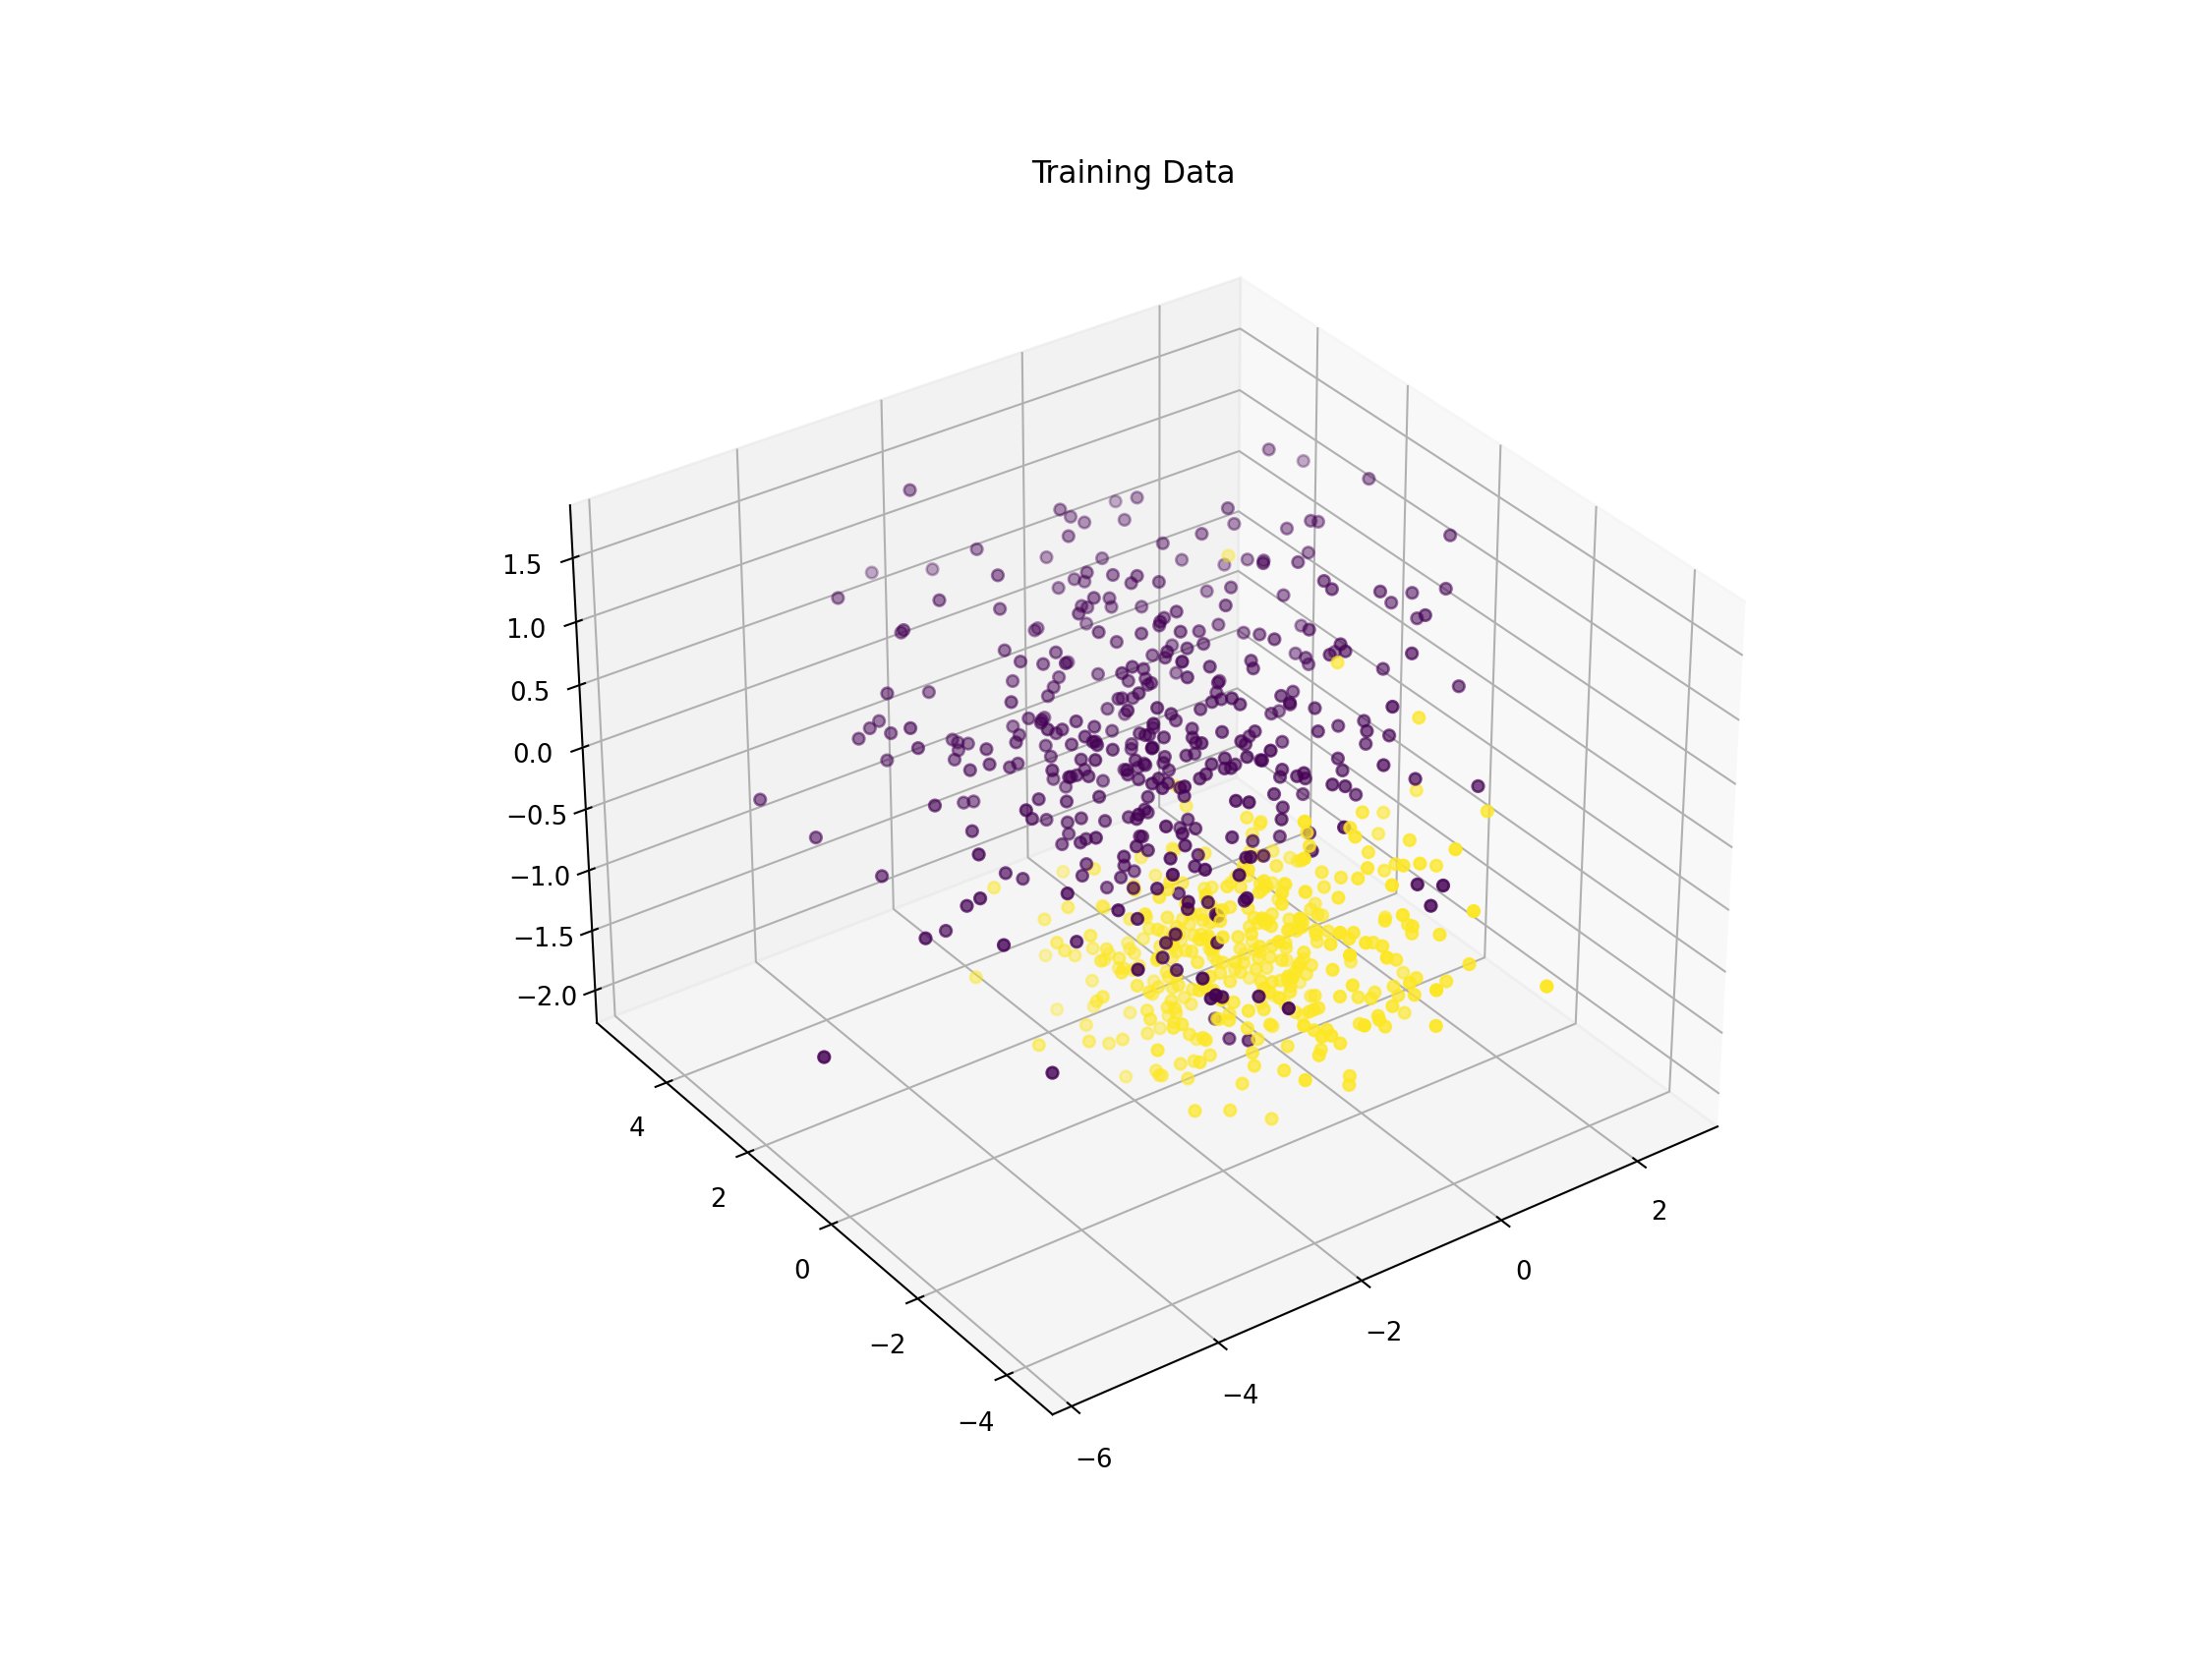

In [20]:
# display the new classes in terms of the first 3 features using an interactive 3d plot
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_2_train[:,0], X_2_train[:,1], X_2_train[:,2], c = Y_2_train)
plt.title('Training Data')
plt.show()

In [21]:
%%time
scikit_clf_fit_score(X_2_train, Y_2_train, X_2_test, Y_2_test, 2)

Logistic Regression: 0.928
Decision Tree Classifier: 0.908
Linear SVC: 0.928
KNN Classifier: 0.944
Random Forest Classifier: 0.932
Gradient Boosting Classfier: 0.948
Wall time: 454 ms


In [22]:
%%time
keras_nn_fit_score(X_2_train, Y_2_train, X_2_test, Y_2_test, 2)

Epoch 1/50
24/24 [==============================] - 0s 1ms/step - loss: 0.6150 - binary_accuracy: 0.6187
Epoch 2/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4061 - binary_accuracy: 0.8693
Epoch 3/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2866 - binary_accuracy: 0.9000
Epoch 4/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2333 - binary_accuracy: 0.9173
Epoch 5/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2076 - binary_accuracy: 0.9280
Epoch 6/50
24/24 [==============================] - 0s 1ms/step - loss: 0.1946 - binary_accuracy: 0.9293
Epoch 7/50
24/24 [==============================] - 0s 1ms/step - loss: 0.1863 - binary_accuracy: 0.9307
Epoch 8/50
24/24 [==============================] - 0s 1ms/step - loss: 0.1811 - binary_accuracy: 0.9333
Epoch 9/50
24/24 [==============================] - 0s 1ms/step - loss: 0.1806 - binary_accuracy: 0.9333
Epoch 10/50
24/24 [==============================] - 0s

In [23]:
%%time
pytorch_nn_fit_score(X_2_train, Y_2_train, X_2_test, Y_2_test, 2)

PyTorch model training...
Epoch: 1, training loss: 0.26589957632233807
Epoch: 2, training loss: 0.18263497226266343
Epoch: 3, training loss: 0.17575118340973844
Epoch: 4, training loss: 0.17119809302147435
Epoch: 5, training loss: 0.16804090169098868
Epoch: 6, training loss: 0.1656689216511205
Epoch: 7, training loss: 0.1632695656376493
Epoch: 8, training loss: 0.16137678298252542
Epoch: 9, training loss: 0.159421113187656
Epoch: 10, training loss: 0.15788882108160904
Epoch: 11, training loss: 0.1560142259912459
Epoch: 12, training loss: 0.1540615127153924
Epoch: 13, training loss: 0.15236224307949336
Epoch: 14, training loss: 0.15110900665597515
Epoch: 15, training loss: 0.1490823542859398
Epoch: 16, training loss: 0.14766772623856259
Epoch: 17, training loss: 0.1459852836954822
Epoch: 18, training loss: 0.1444501473797794
Epoch: 19, training loss: 0.1426896029573984
Epoch: 20, training loss: 0.14126376634728788
Epoch: 21, training loss: 0.14005169012339183
Epoch: 22, training loss: 0

In [24]:
accuracy_df

Dataset 1 Dataset 2 Dataset 3 Dataset 4 Dataset 5
Logistic Regression             0.928     0.928       NaN       NaN       NaN
Decision Tree Classifier         0.94     0.908       NaN       NaN       NaN
Linear SVC                      0.928     0.928       NaN       NaN       NaN
KNN Classifier                  0.952     0.944       NaN       NaN       NaN
Random Forest Classifier        0.952     0.932       NaN       NaN       NaN
Gradient Boosting Classfier     0.952     0.948       NaN       NaN       NaN
Keras NN                        0.944     0.948       NaN       NaN       NaN
PyTorch NN                      0.956     0.948       NaN       NaN       NaN

All models achieved over 90% accuracy again.

For the next dataset, I will use 7 features broken down into 4 informative, 2 redundant (linear combinations of informative features), and 1 repeated (randomly chosen from the previous 6).

In [25]:
X_3, Y_3 = make_classification(n_samples = 1000,
                           n_features = 7,
                           n_informative = 4,
                           n_redundant = 2,
                           n_repeated = 1,
                           n_clusters_per_class = 1,
                           random_state = 47)

X_3_train, X_3_test, Y_3_train, Y_3_test = train_test_split(X_3, Y_3, 
                                                            test_size = 0.25,
                                                            random_state = 47)

In [26]:
%%time
scikit_clf_fit_score(X_3_train, Y_3_train, X_3_test, Y_3_test, 3)

Logistic Regression: 0.884
Decision Tree Classifier: 0.848
Linear SVC: 0.88
KNN Classifier: 0.9
Random Forest Classifier: 0.908
Gradient Boosting Classfier: 0.892
Wall time: 589 ms


In [27]:
%%time
keras_nn_fit_score(X_3_train, Y_3_train, X_3_test, Y_3_test, 3)

Epoch 1/50
24/24 [==============================] - 0s 1ms/step - loss: 0.6452 - binary_accuracy: 0.5853
Epoch 2/50
24/24 [==============================] - 0s 901us/step - loss: 0.4675 - binary_accuracy: 0.8667
Epoch 3/50
24/24 [==============================] - 0s 756us/step - loss: 0.3465 - binary_accuracy: 0.9080
Epoch 4/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2694 - binary_accuracy: 0.9120
Epoch 5/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2321 - binary_accuracy: 0.9173
Epoch 6/50
24/24 [==============================] - 0s 837us/step - loss: 0.2146 - binary_accuracy: 0.9173
Epoch 7/50
24/24 [==============================] - 0s 658us/step - loss: 0.2057 - binary_accuracy: 0.9187
Epoch 8/50
24/24 [==============================] - 0s 833us/step - loss: 0.1995 - binary_accuracy: 0.9200
Epoch 9/50
24/24 [==============================] - 0s 720us/step - loss: 0.1967 - binary_accuracy: 0.9200
Epoch 10/50
24/24 [========================

In [28]:
%%time
pytorch_nn_fit_score(X_3_train, Y_3_train, X_3_test, Y_3_test, 3)

PyTorch model training...
Epoch: 1, training loss: 0.33138408774230627
Epoch: 2, training loss: 0.2117633083204079
Epoch: 3, training loss: 0.20219484957609288
Epoch: 4, training loss: 0.19695283399570082
Epoch: 5, training loss: 0.19308204240510168
Epoch: 6, training loss: 0.1898208515970194
Epoch: 7, training loss: 0.18690852988922052
Epoch: 8, training loss: 0.18492391417557186
Epoch: 9, training loss: 0.1829481949041595
Epoch: 10, training loss: 0.18130996782851647
Epoch: 11, training loss: 0.18006843781116974
Epoch: 12, training loss: 0.1786893258376837
Epoch: 13, training loss: 0.17757717936781653
Epoch: 14, training loss: 0.17604796168091966
Epoch: 15, training loss: 0.1750221673503006
Epoch: 16, training loss: 0.1737963794845106
Epoch: 17, training loss: 0.172602072307962
Epoch: 18, training loss: 0.1717742653515952
Epoch: 19, training loss: 0.17089843824843887
Epoch: 20, training loss: 0.16981453697553395
Epoch: 21, training loss: 0.16916326299456613
Epoch: 22, training loss: 

In [29]:
accuracy_df

Dataset 1 Dataset 2 Dataset 3 Dataset 4 Dataset 5
Logistic Regression             0.928     0.928     0.884       NaN       NaN
Decision Tree Classifier         0.94     0.908     0.848       NaN       NaN
Linear SVC                      0.928     0.928      0.88       NaN       NaN
KNN Classifier                  0.952     0.944       0.9       NaN       NaN
Random Forest Classifier        0.952     0.932     0.908       NaN       NaN
Gradient Boosting Classfier     0.952     0.948     0.892       NaN       NaN
Keras NN                        0.944     0.948       0.9       NaN       NaN
PyTorch NN                      0.956     0.948     0.896       NaN       NaN

In [30]:
X_4, Y_4 = make_classification(n_samples = 1000,
                           n_features = 10,
                           n_informative = 5,
                           n_redundant = 3,
                           n_repeated = 2,
                           n_clusters_per_class = 1,
                           random_state = 47)

X_4_train, X_4_test, Y_4_train, Y_4_test = train_test_split(X_4, Y_4, 
                                                            test_size = 0.25,
                                                            random_state = 47)

The next dataset will consist of 10 features with the following breakdown: 5 informative, 3 redundant, 2 repeated.

In [31]:
%%time
scikit_clf_fit_score(X_4_train, Y_4_train, X_4_test, Y_4_test, 4)

Logistic Regression: 0.88
Decision Tree Classifier: 0.928
Linear SVC: 0.88
KNN Classifier: 0.956
Random Forest Classifier: 0.948
Gradient Boosting Classfier: 0.952
Wall time: 747 ms


In [32]:
%%time
keras_nn_fit_score(X_4_train, Y_4_train, X_4_test, Y_4_test, 4)

Epoch 1/50
24/24 [==============================] - 0s 831us/step - loss: 0.6046 - binary_accuracy: 0.6760
Epoch 2/50
24/24 [==============================] - 0s 986us/step - loss: 0.4313 - binary_accuracy: 0.8453
Epoch 3/50
24/24 [==============================] - 0s 837us/step - loss: 0.3474 - binary_accuracy: 0.8720
Epoch 4/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2935 - binary_accuracy: 0.8893
Epoch 5/50
24/24 [==============================] - 0s 830us/step - loss: 0.2592 - binary_accuracy: 0.8987
Epoch 6/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2354 - binary_accuracy: 0.9200
Epoch 7/50
24/24 [==============================] - 0s 896us/step - loss: 0.2163 - binary_accuracy: 0.9227
Epoch 8/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2025 - binary_accuracy: 0.9267
Epoch 9/50
24/24 [==============================] - 0s 939us/step - loss: 0.1919 - binary_accuracy: 0.9293
Epoch 10/50
24/24 [========================

In [33]:
%%time
pytorch_nn_fit_score(X_4_train, Y_4_train, X_4_test, Y_4_test, 4)

PyTorch model training...
Epoch: 1, training loss: 0.3049327414218499
Epoch: 2, training loss: 0.16877026668954043
Epoch: 3, training loss: 0.14860663894972578
Epoch: 4, training loss: 0.13970292573741938
Epoch: 5, training loss: 0.1343830111221588
Epoch: 6, training loss: 0.1304615125204014
Epoch: 7, training loss: 0.12755929641224611
Epoch: 8, training loss: 0.12435008803728029
Epoch: 9, training loss: 0.12345111962728908
Epoch: 10, training loss: 0.11976278064400497
Epoch: 11, training loss: 0.11730871451097254
Epoch: 12, training loss: 0.11756506185702477
Epoch: 13, training loss: 0.11503672785368914
Epoch: 14, training loss: 0.11407129240767437
Epoch: 15, training loss: 0.11231500822859901
Epoch: 16, training loss: 0.10915399004117224
Epoch: 17, training loss: 0.10894589693920094
Epoch: 18, training loss: 0.10668821610691795
Epoch: 19, training loss: 0.10673823215328442
Epoch: 20, training loss: 0.10442561350871488
Epoch: 21, training loss: 0.10341007231764113
Epoch: 22, training 

In [34]:
accuracy_df

Dataset 1 Dataset 2 Dataset 3 Dataset 4 Dataset 5
Logistic Regression             0.928     0.928     0.884      0.88       NaN
Decision Tree Classifier         0.94     0.908     0.848     0.928       NaN
Linear SVC                      0.928     0.928      0.88      0.88       NaN
KNN Classifier                  0.952     0.944       0.9     0.956       NaN
Random Forest Classifier        0.952     0.932     0.908     0.948       NaN
Gradient Boosting Classfier     0.952     0.948     0.892     0.952       NaN
Keras NN                        0.944     0.948       0.9     0.932       NaN
PyTorch NN                      0.956     0.948     0.896     0.948       NaN

In [35]:
X_5, Y_5 = make_classification(n_samples = 1000,
                           n_features = 20,
                           n_informative = 7,
                           n_redundant = 7,
                           n_repeated = 6,
                           n_clusters_per_class = 1,
                           random_state = 47)

X_5_train, X_5_test, Y_5_train, Y_5_test = train_test_split(X_5, Y_5, 
                                                            test_size = 0.25,
                                                            random_state = 47)

In [36]:
%%time
scikit_clf_fit_score(X_5_train, Y_5_train, X_5_test, Y_5_test, 5)

Logistic Regression: 0.96
Decision Tree Classifier: 0.94
Linear SVC: 0.96
KNN Classifier: 0.972


C:\Users\metal\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Random Forest Classifier: 0.968
Gradient Boosting Classfier: 0.968
Wall time: 902 ms


In [37]:
%%time
keras_nn_fit_score(X_5_train, Y_5_train, X_5_test, Y_5_test, 5)

Epoch 1/50
24/24 [==============================] - 0s 2ms/step - loss: 0.6002 - binary_accuracy: 0.6787
Epoch 2/50
24/24 [==============================] - 0s 410us/step - loss: 0.3092 - binary_accuracy: 0.9133
Epoch 3/50
24/24 [==============================] - 0s 436us/step - loss: 0.1828 - binary_accuracy: 0.9653
Epoch 4/50
24/24 [==============================] - 0s 420us/step - loss: 0.1254 - binary_accuracy: 0.9760
Epoch 5/50
24/24 [==============================] - 0s 438us/step - loss: 0.0983 - binary_accuracy: 0.9853
Epoch 6/50
24/24 [==============================] - 0s 1ms/step - loss: 0.0824 - binary_accuracy: 0.9880
Epoch 7/50
24/24 [==============================] - 0s 1ms/step - loss: 0.0731 - binary_accuracy: 0.9880
Epoch 8/50
24/24 [==============================] - 0s 475us/step - loss: 0.0670 - binary_accuracy: 0.9867
Epoch 9/50
24/24 [==============================] - 0s 453us/step - loss: 0.0626 - binary_accuracy: 0.9893
Epoch 10/50
24/24 [========================

In [38]:
%%time
pytorch_nn_fit_score(X_5_train, Y_5_train, X_5_test, Y_5_test, 5)

PyTorch model training...
Epoch: 1, training loss: 0.19814517542485494
Epoch: 2, training loss: 0.07046957525517313
Epoch: 3, training loss: 0.06109998311239218
Epoch: 4, training loss: 0.05288876831067635
Epoch: 5, training loss: 0.04714059697045165
Epoch: 6, training loss: 0.04169556297020358
Epoch: 7, training loss: 0.03750851774896146
Epoch: 8, training loss: 0.03459969483720691
Epoch: 9, training loss: 0.03074649792525031
Epoch: 10, training loss: 0.03459886174268013
Epoch: 11, training loss: 0.03155972990853655
Epoch: 12, training loss: 0.025604419260805724
Epoch: 13, training loss: 0.022917250891705994
Epoch: 14, training loss: 0.021540987784655782
Epoch: 15, training loss: 0.02238708997398544
Epoch: 16, training loss: 0.04043353060966435
Epoch: 17, training loss: 0.024990311862002082
Epoch: 18, training loss: 0.02686814189609538
Epoch: 19, training loss: 0.015895265513518324
Epoch: 20, training loss: 0.0238724196188341
Epoch: 21, training loss: 0.02585424479930693
Epoch: 22, tr

In [39]:
accuracy_df

Dataset 1 Dataset 2 Dataset 3 Dataset 4 Dataset 5
Logistic Regression             0.928     0.928     0.884      0.88      0.96
Decision Tree Classifier         0.94     0.908     0.848     0.928      0.94
Linear SVC                      0.928     0.928      0.88      0.88      0.96
KNN Classifier                  0.952     0.944       0.9     0.956     0.972
Random Forest Classifier        0.952     0.932     0.908     0.948     0.968
Gradient Boosting Classfier     0.952     0.948     0.892     0.952     0.968
Keras NN                        0.944     0.948       0.9     0.932     0.972
PyTorch NN                      0.956     0.948     0.896     0.948     0.964

In [40]:
moon_accuracy_df = pd.DataFrame(columns = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4', 'Dataset 5'])

In [41]:
from sklearn.datasets import make_moons

moon_X, moon_Y = make_moons(1000, noise = 0.1, random_state=47)

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(moon_X, moon_Y, 
                                                    test_size = 0.25, random_state = 47)

<IPython.core.display.Javascript object>


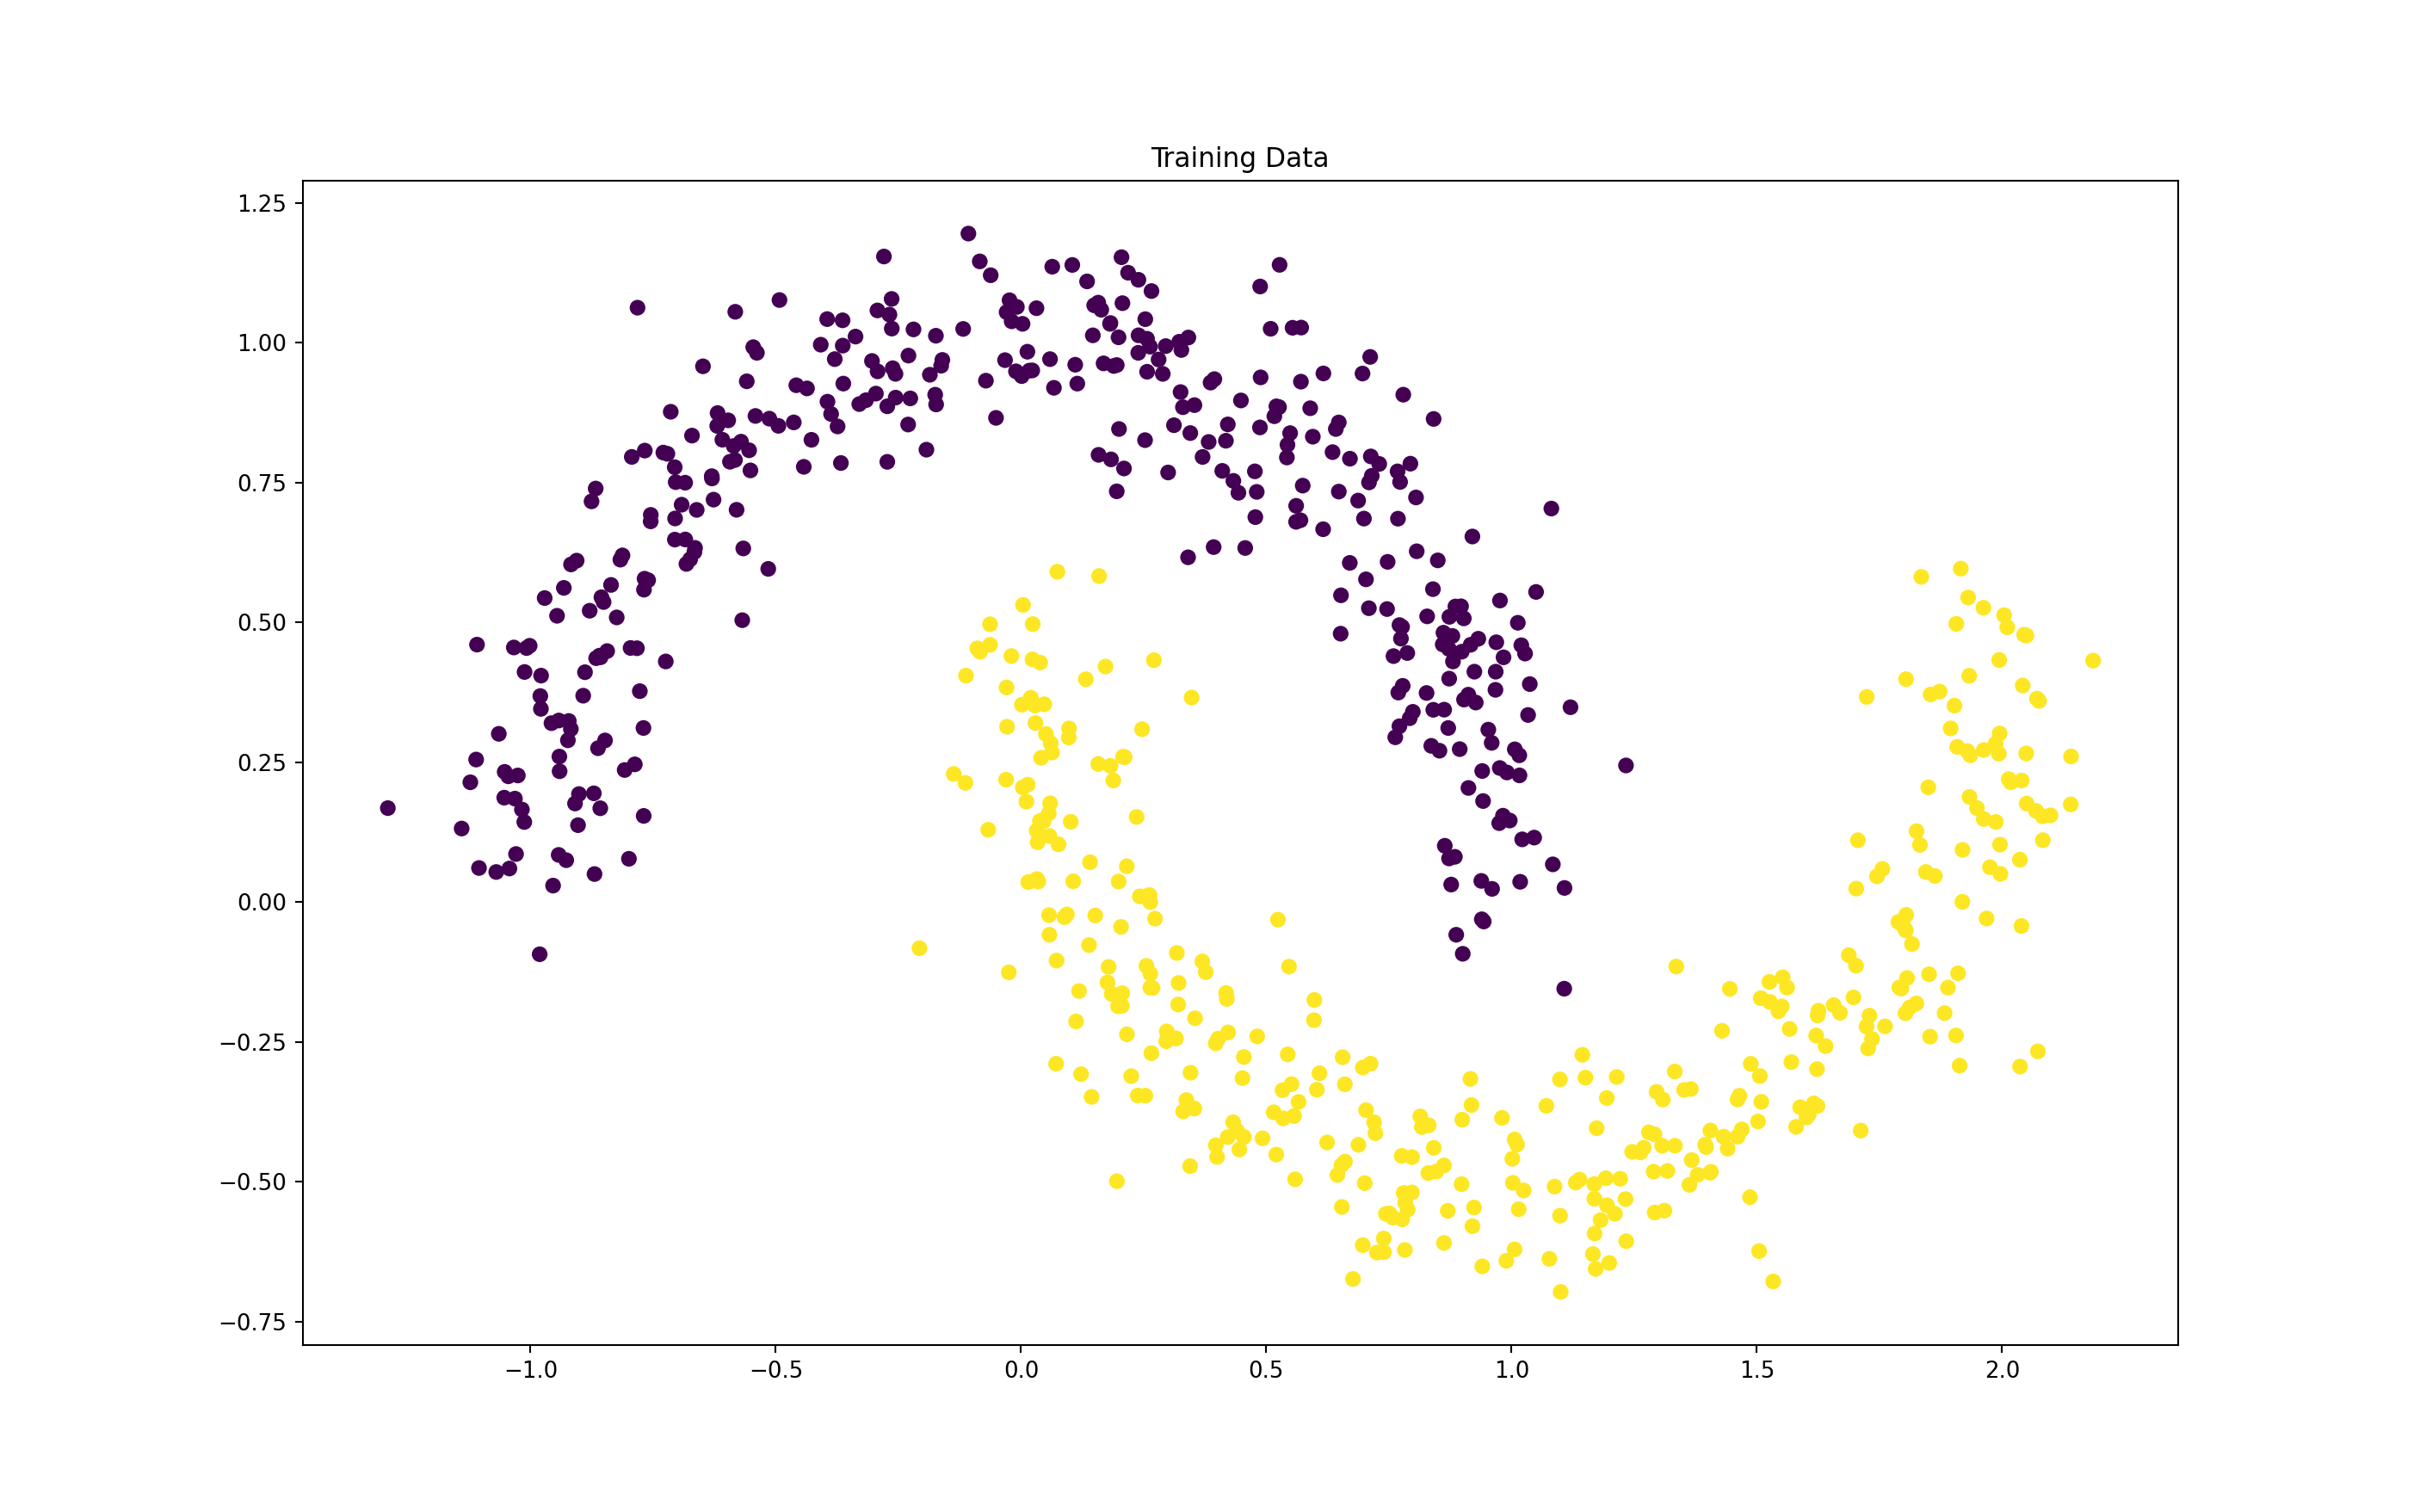

In [43]:
plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], X_train[:,1], c = Y_train)
plt.title('Training Data')
plt.show()

<IPython.core.display.Javascript object>


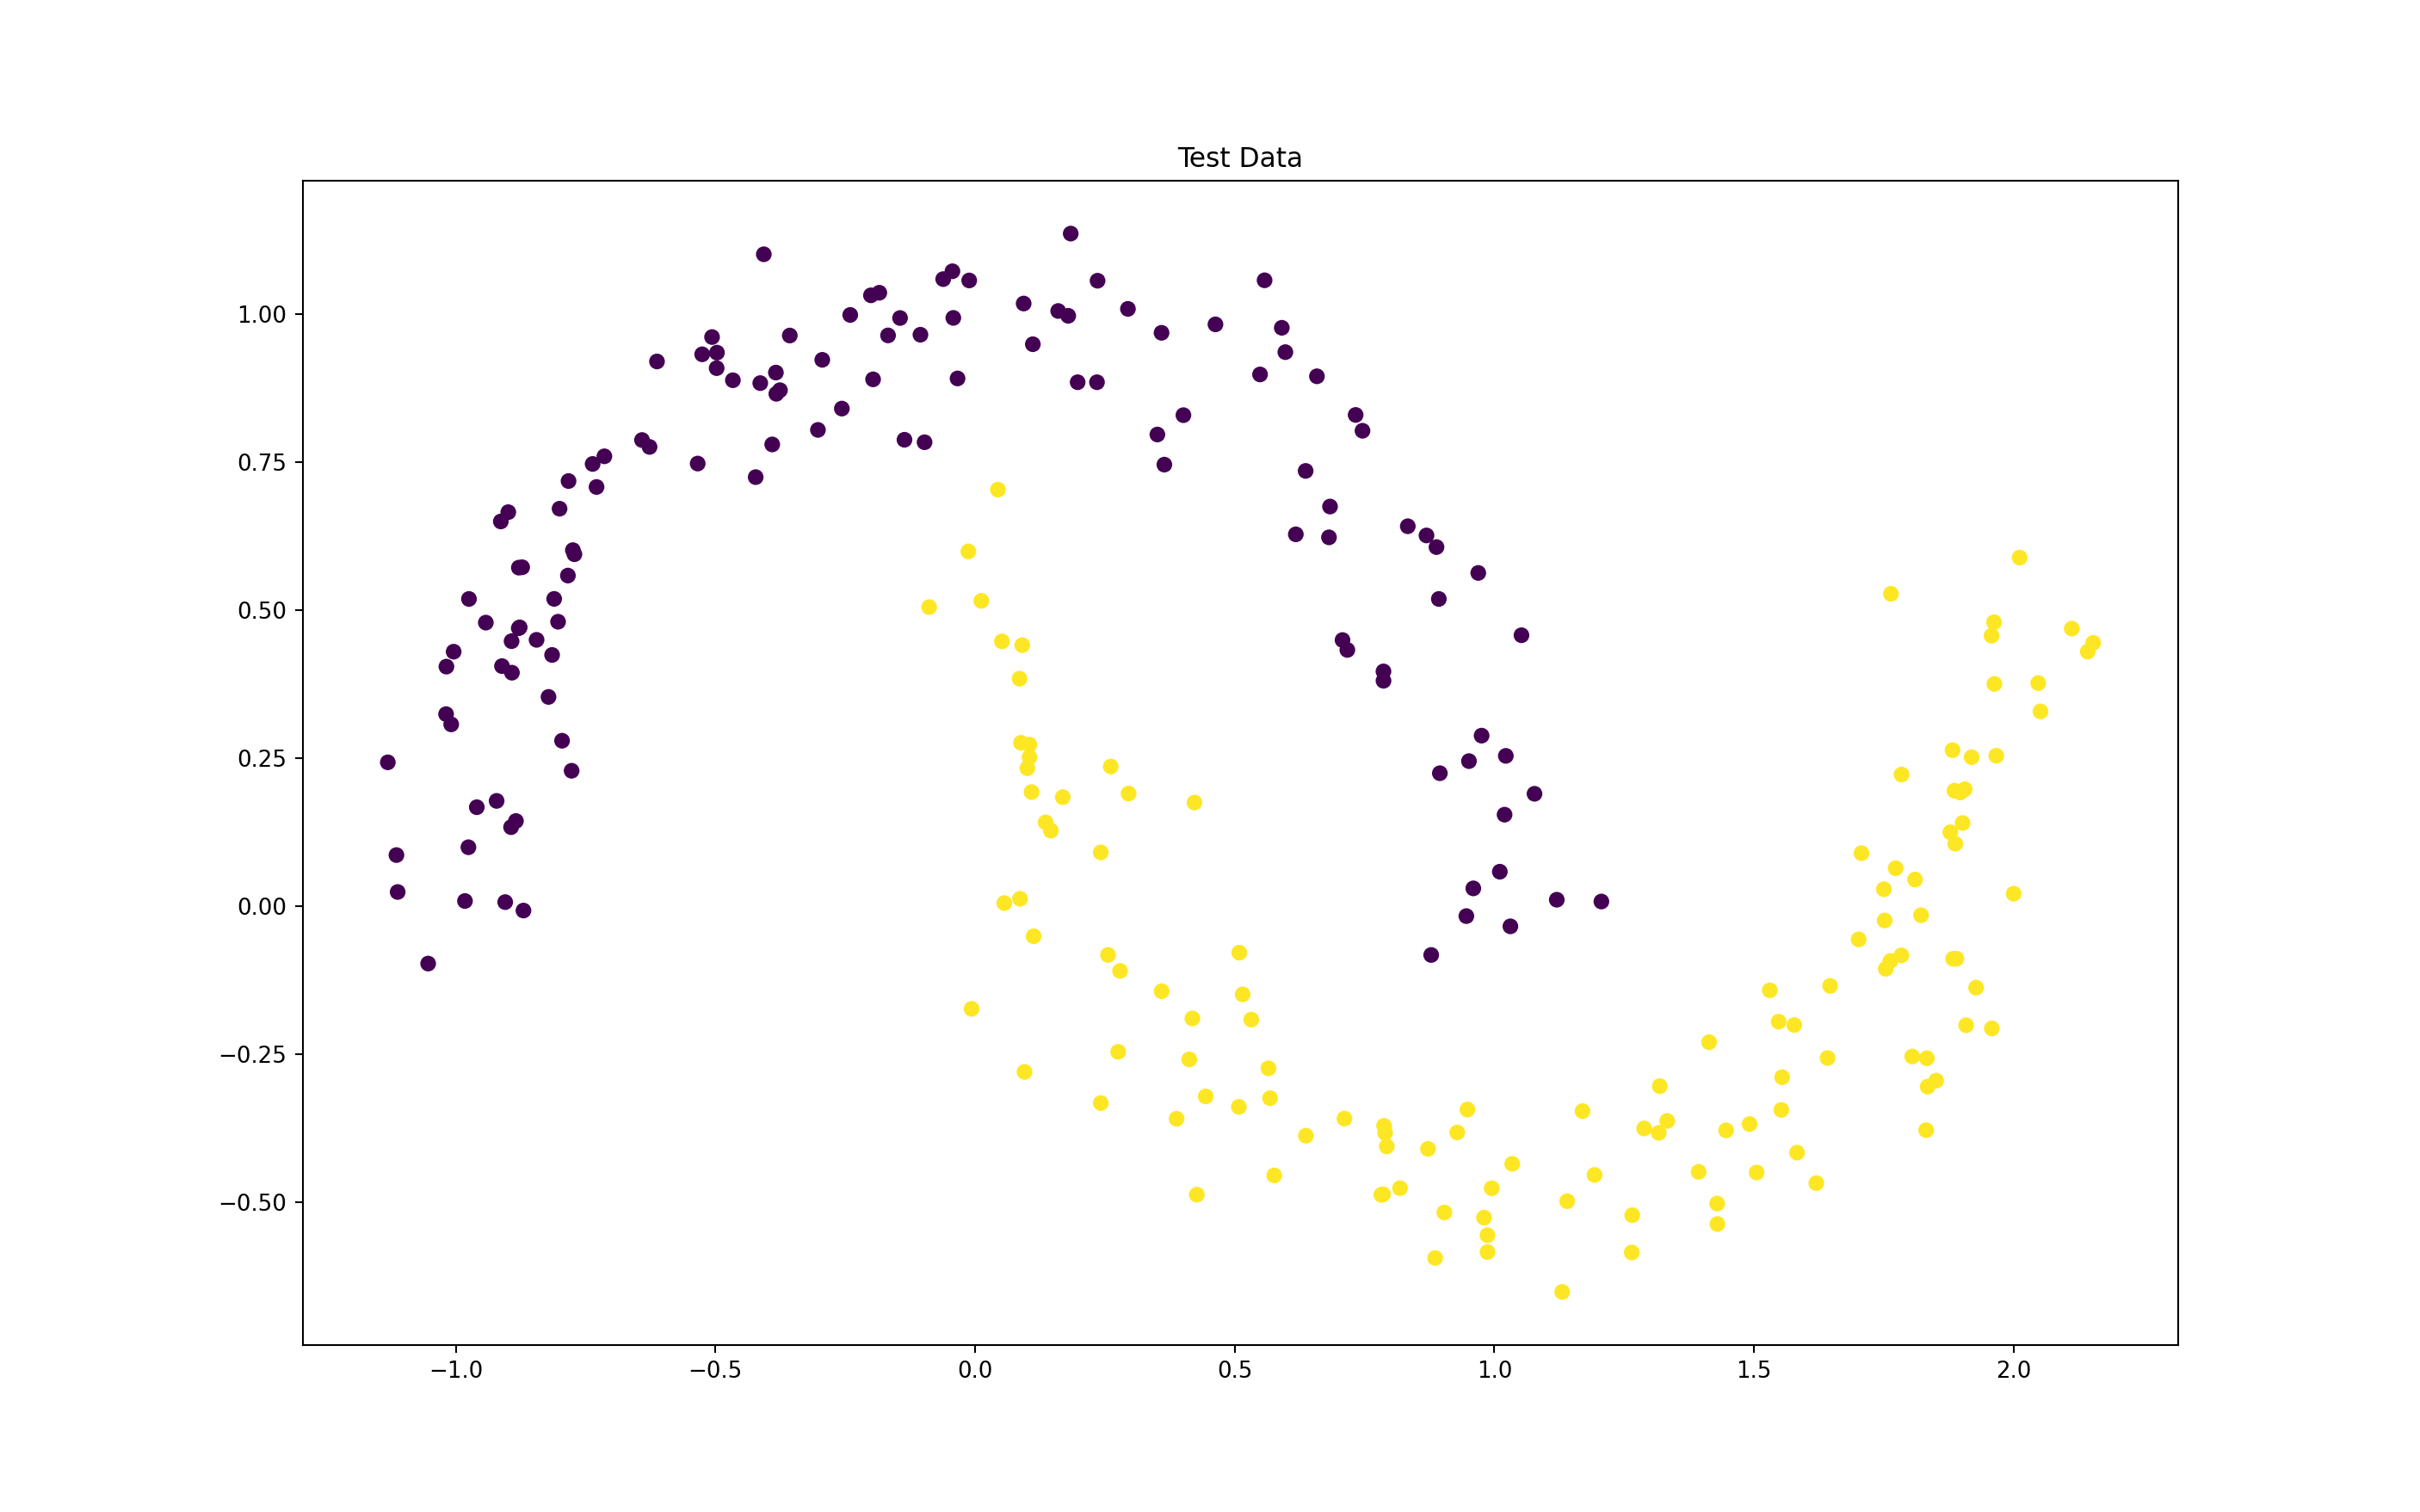

In [44]:
plt.figure(figsize=(8,5))
plt.scatter(X_test[:,0], X_test[:,1], c = Y_test)
plt.title('Test Data')
plt.show()

In [45]:
# modify the functions to use the new DataFrame

def moon_scikit_clf_fit_score(x_train, y_train, x_test, y_test, dataset_num):
    
    # loop over each classifier in clf_list, fit, score, add score to accuracy_df
    dataset = f'Dataset {dataset_num}'
    
    for i in range(6):
        clf_list[i].fit(x_train, y_train)
        score = clf_list[i].score(x_test, y_test)
        moon_accuracy_df.loc[clf_names[i], dataset] = score
        print(f'{clf_names[i]}: {score}')

In [46]:
def moon_keras_nn_fit_score(x_train, y_train, x_test, y_test, dataset_num, n_epochs = 50):
    
    dataset = f'Dataset {dataset_num}'
    
    # three layer model with ReLU applied to the first two layers
    # and sigmoid to the last one
    model = Sequential([
    Dense(30, input_shape=(x_train.shape[1],), activation = 'relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')])
    
    # compile the model using binary crossentropy as the loss function and
    # binary accuracy as the evaluation metric
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    model.fit(x_train, y_train, epochs = n_epochs)
    
    # evaluate using the test data
    results = model.evaluate(x_test, y_test)
    moon_accuracy_df.loc['Keras NN', dataset] = float(f'{results[1]:.3}')
    print(results)

In [47]:
def moon_pytorch_nn_fit_score(x_train, y_train, x_test, y_test, dataset_num, n_epochs = 50):
    
    dataset = f'Dataset {dataset_num}'
    
    # initialize a neural network
    net = TorchBinaryClassifier(x_train.shape[1])
    
    # get data loaders from the training and testing data
    train_loader, test_loader = pytorch_loaders(x_train, y_train, x_test, y_test)
    
    # train the network
    pytorch_train(net, train_loader)
    
    # add a blank line for a clearer print-out
    print('\n')
    # test the network
    accuracy = pytorch_test(net, test_loader)
    moon_accuracy_df.loc['PyTorch NN', dataset] = accuracy

In [48]:
%%time
moon_scikit_clf_fit_score(X_train, Y_train, X_test, Y_test, 1)

Logistic Regression: 0.88
Decision Tree Classifier: 0.992
Linear SVC: 0.88
KNN Classifier: 0.996
Random Forest Classifier: 0.988
Gradient Boosting Classfier: 0.992
Wall time: 332 ms


In [49]:
%%time
moon_keras_nn_fit_score(X_train, Y_train, X_test, Y_test, 1)

Epoch 1/50
24/24 [==============================] - 0s 874us/step - loss: 0.5855 - binary_accuracy: 0.8440
Epoch 2/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4816 - binary_accuracy: 0.8360
Epoch 3/50
24/24 [==============================] - 0s 1ms/step - loss: 0.3970 - binary_accuracy: 0.8480
Epoch 4/50
24/24 [==============================] - 0s 906us/step - loss: 0.3382 - binary_accuracy: 0.8573
Epoch 5/50
24/24 [==============================] - 0s 1ms/step - loss: 0.3041 - binary_accuracy: 0.8613
Epoch 6/50
24/24 [==============================] - 0s 906us/step - loss: 0.2794 - binary_accuracy: 0.8787
Epoch 7/50
24/24 [==============================] - 0s 935us/step - loss: 0.2619 - binary_accuracy: 0.8827
Epoch 8/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2496 - binary_accuracy: 0.8867
Epoch 9/50
24/24 [==============================] - ETA: 0s - loss: 0.1832 - binary_accuracy: 0.937 - 0s 792us/step - loss: 0.2374 - binary_accuracy: 0.

In [50]:
%%time
moon_pytorch_nn_fit_score(X_train, Y_train, X_test, Y_test, 1)

PyTorch model training...
Epoch: 1, training loss: 0.32475331155459086
Epoch: 2, training loss: 0.1250877417905722
Epoch: 3, training loss: 0.061479116395346256
Epoch: 4, training loss: 0.03221115399852715
Epoch: 5, training loss: 0.019519945515255037
Epoch: 6, training loss: 0.013174883716313427
Epoch: 7, training loss: 0.009508325902890987
Epoch: 8, training loss: 0.007351642292912061
Epoch: 9, training loss: 0.006188729425193155
Epoch: 10, training loss: 0.004931786731044989
Epoch: 11, training loss: 0.004413304367120721
Epoch: 12, training loss: 0.003618263475718038
Epoch: 13, training loss: 0.003360193935713009
Epoch: 14, training loss: 0.002883701281056157
Epoch: 15, training loss: 0.0026665757829031802
Epoch: 16, training loss: 0.0024121008598715055
Epoch: 17, training loss: 0.002295920617377836
Epoch: 18, training loss: 0.0022368441851484512
Epoch: 19, training loss: 0.0021025448231019937
Epoch: 20, training loss: 0.0019390899500886577
Epoch: 21, training loss: 0.00192327161267

In [51]:
moon_accuracy_df

Dataset 1 Dataset 2 Dataset 3 Dataset 4
Logistic Regression              0.88       NaN       NaN       NaN
Decision Tree Classifier        0.992       NaN       NaN       NaN
Linear SVC                       0.88       NaN       NaN       NaN
KNN Classifier                  0.996       NaN       NaN       NaN
Random Forest Classifier        0.988       NaN       NaN       NaN
Gradient Boosting Classfier     0.992       NaN       NaN       NaN
Keras NN                        0.992       NaN       NaN       NaN
PyTorch NN                          1       NaN       NaN       NaN

In [52]:
moon_X_2, moon_Y_2 = make_moons(1000, noise = 0.3, random_state=47)
X_train, X_test, Y_train, Y_test = train_test_split(moon_X_2, moon_Y_2, 
                                                    test_size = 0.25, random_state = 47)

<IPython.core.display.Javascript object>


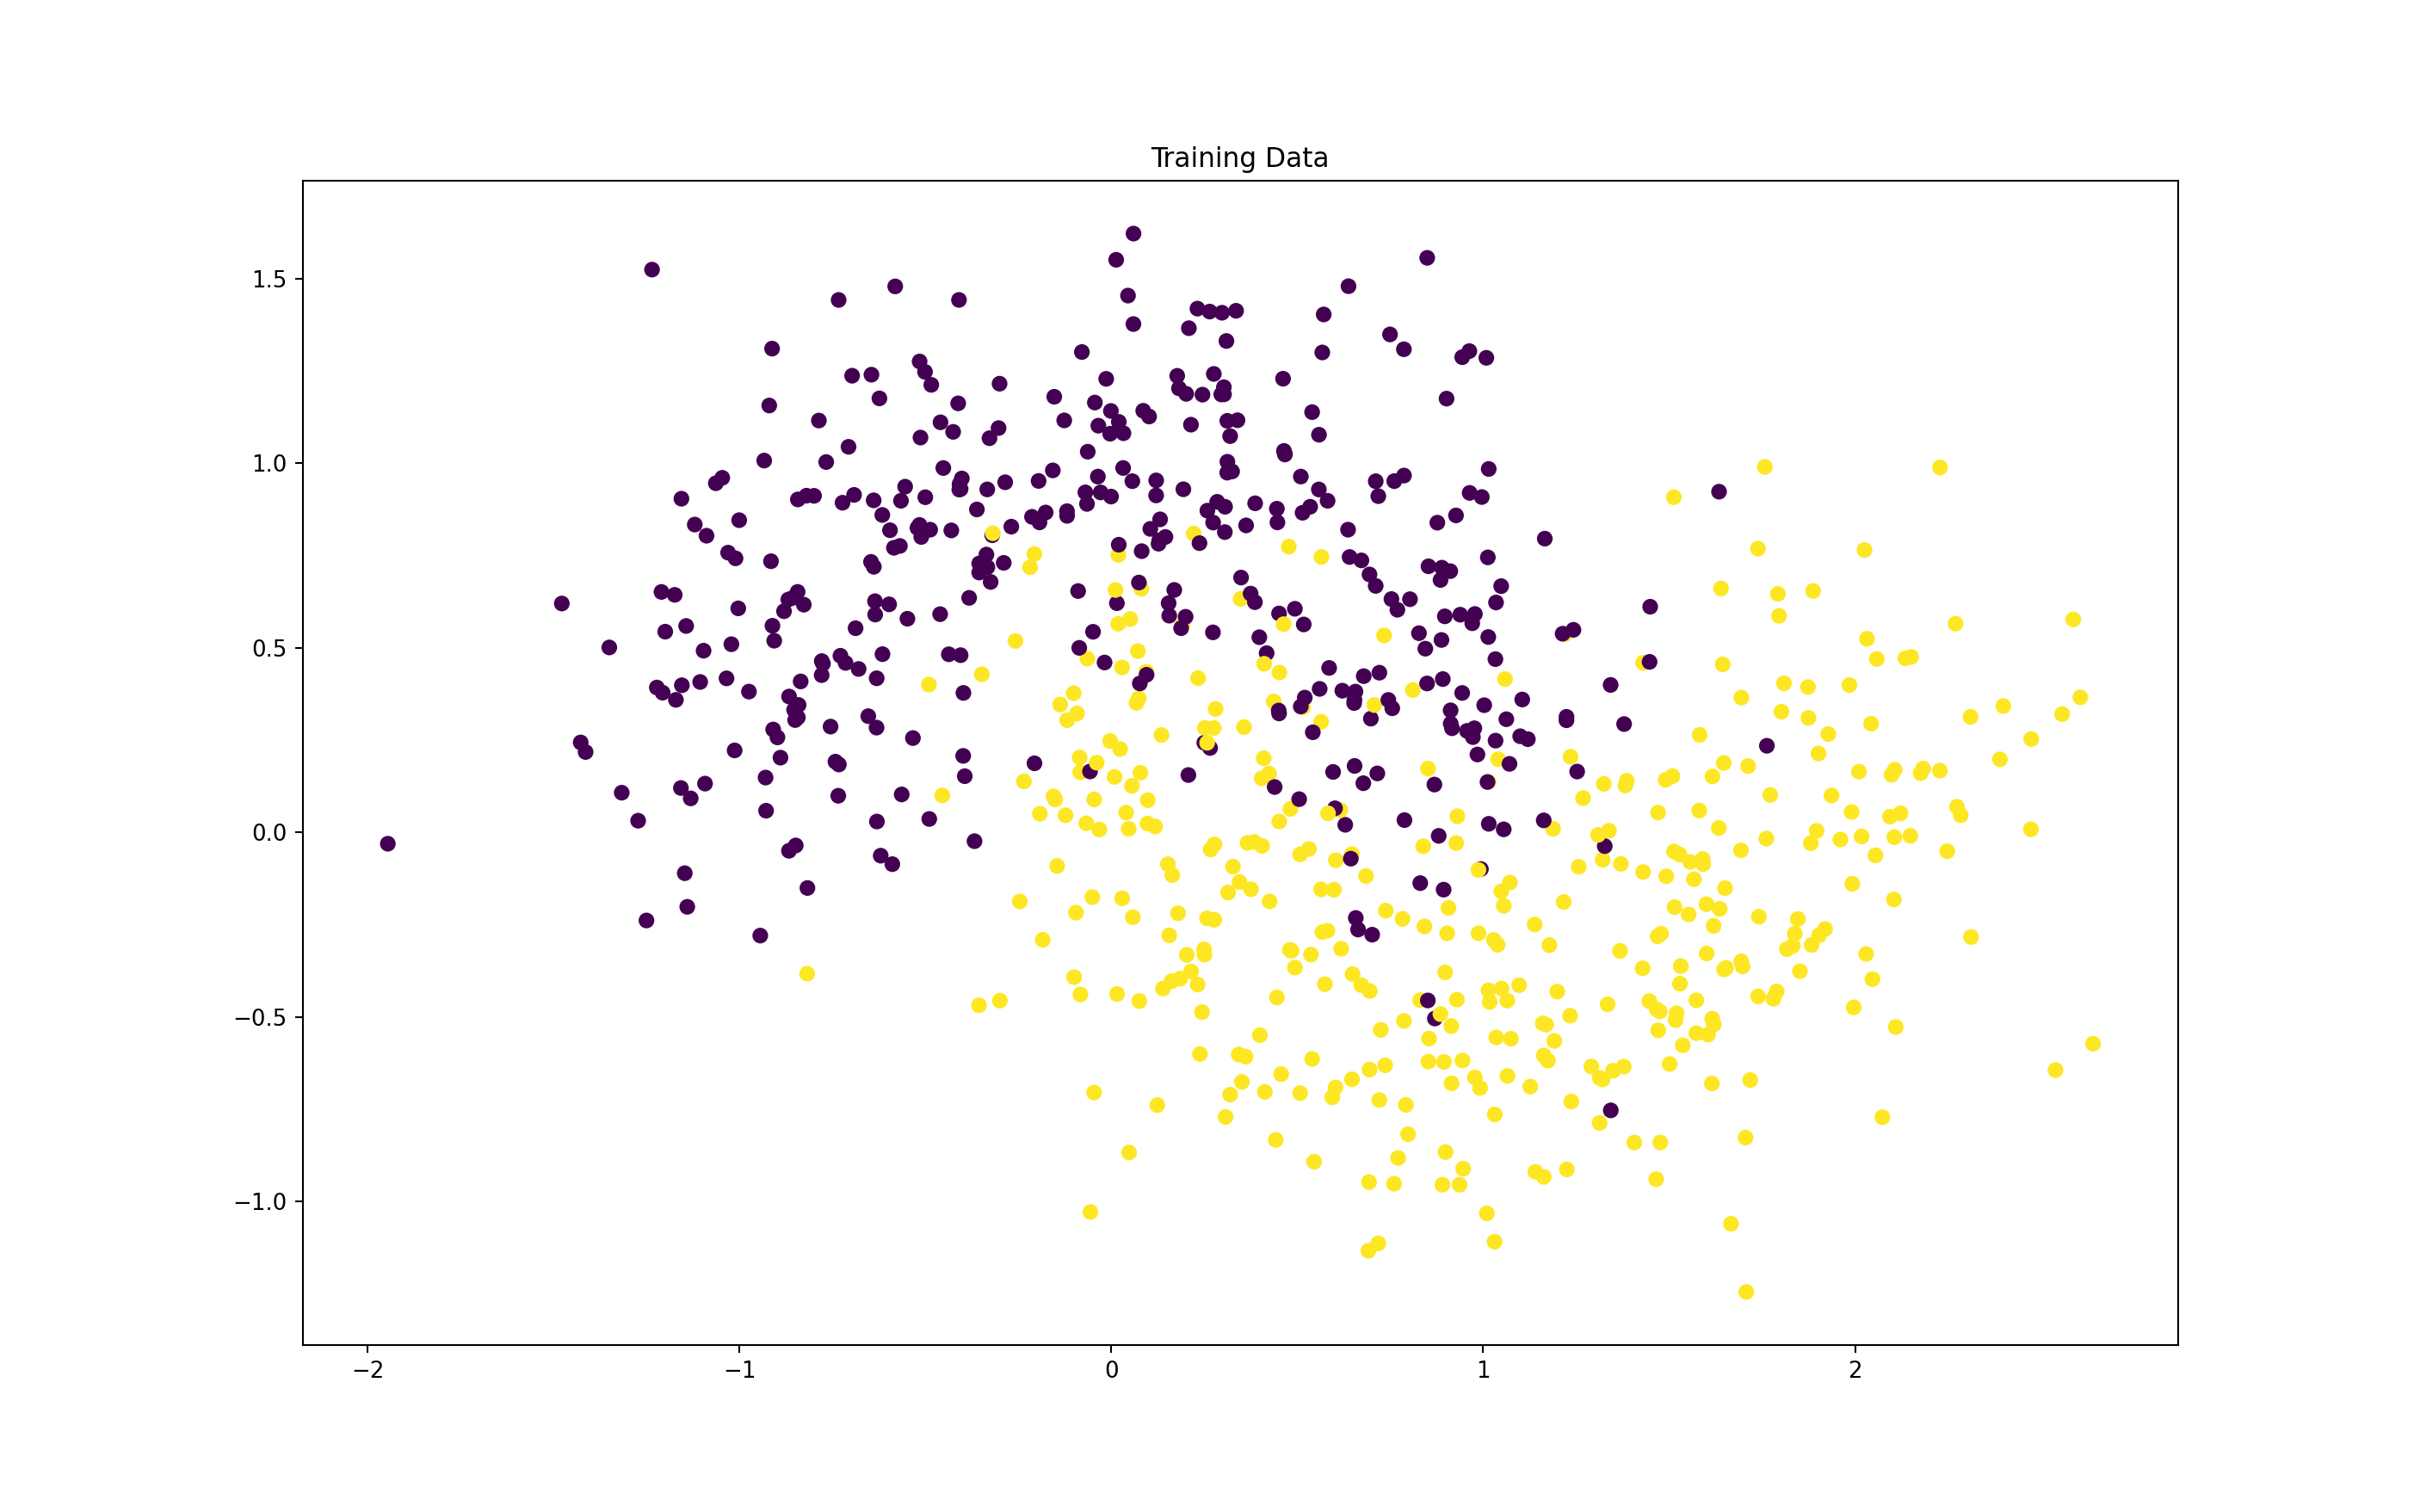

In [53]:
plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], X_train[:,1], c = Y_train)
plt.title('Training Data')
plt.show()

<IPython.core.display.Javascript object>


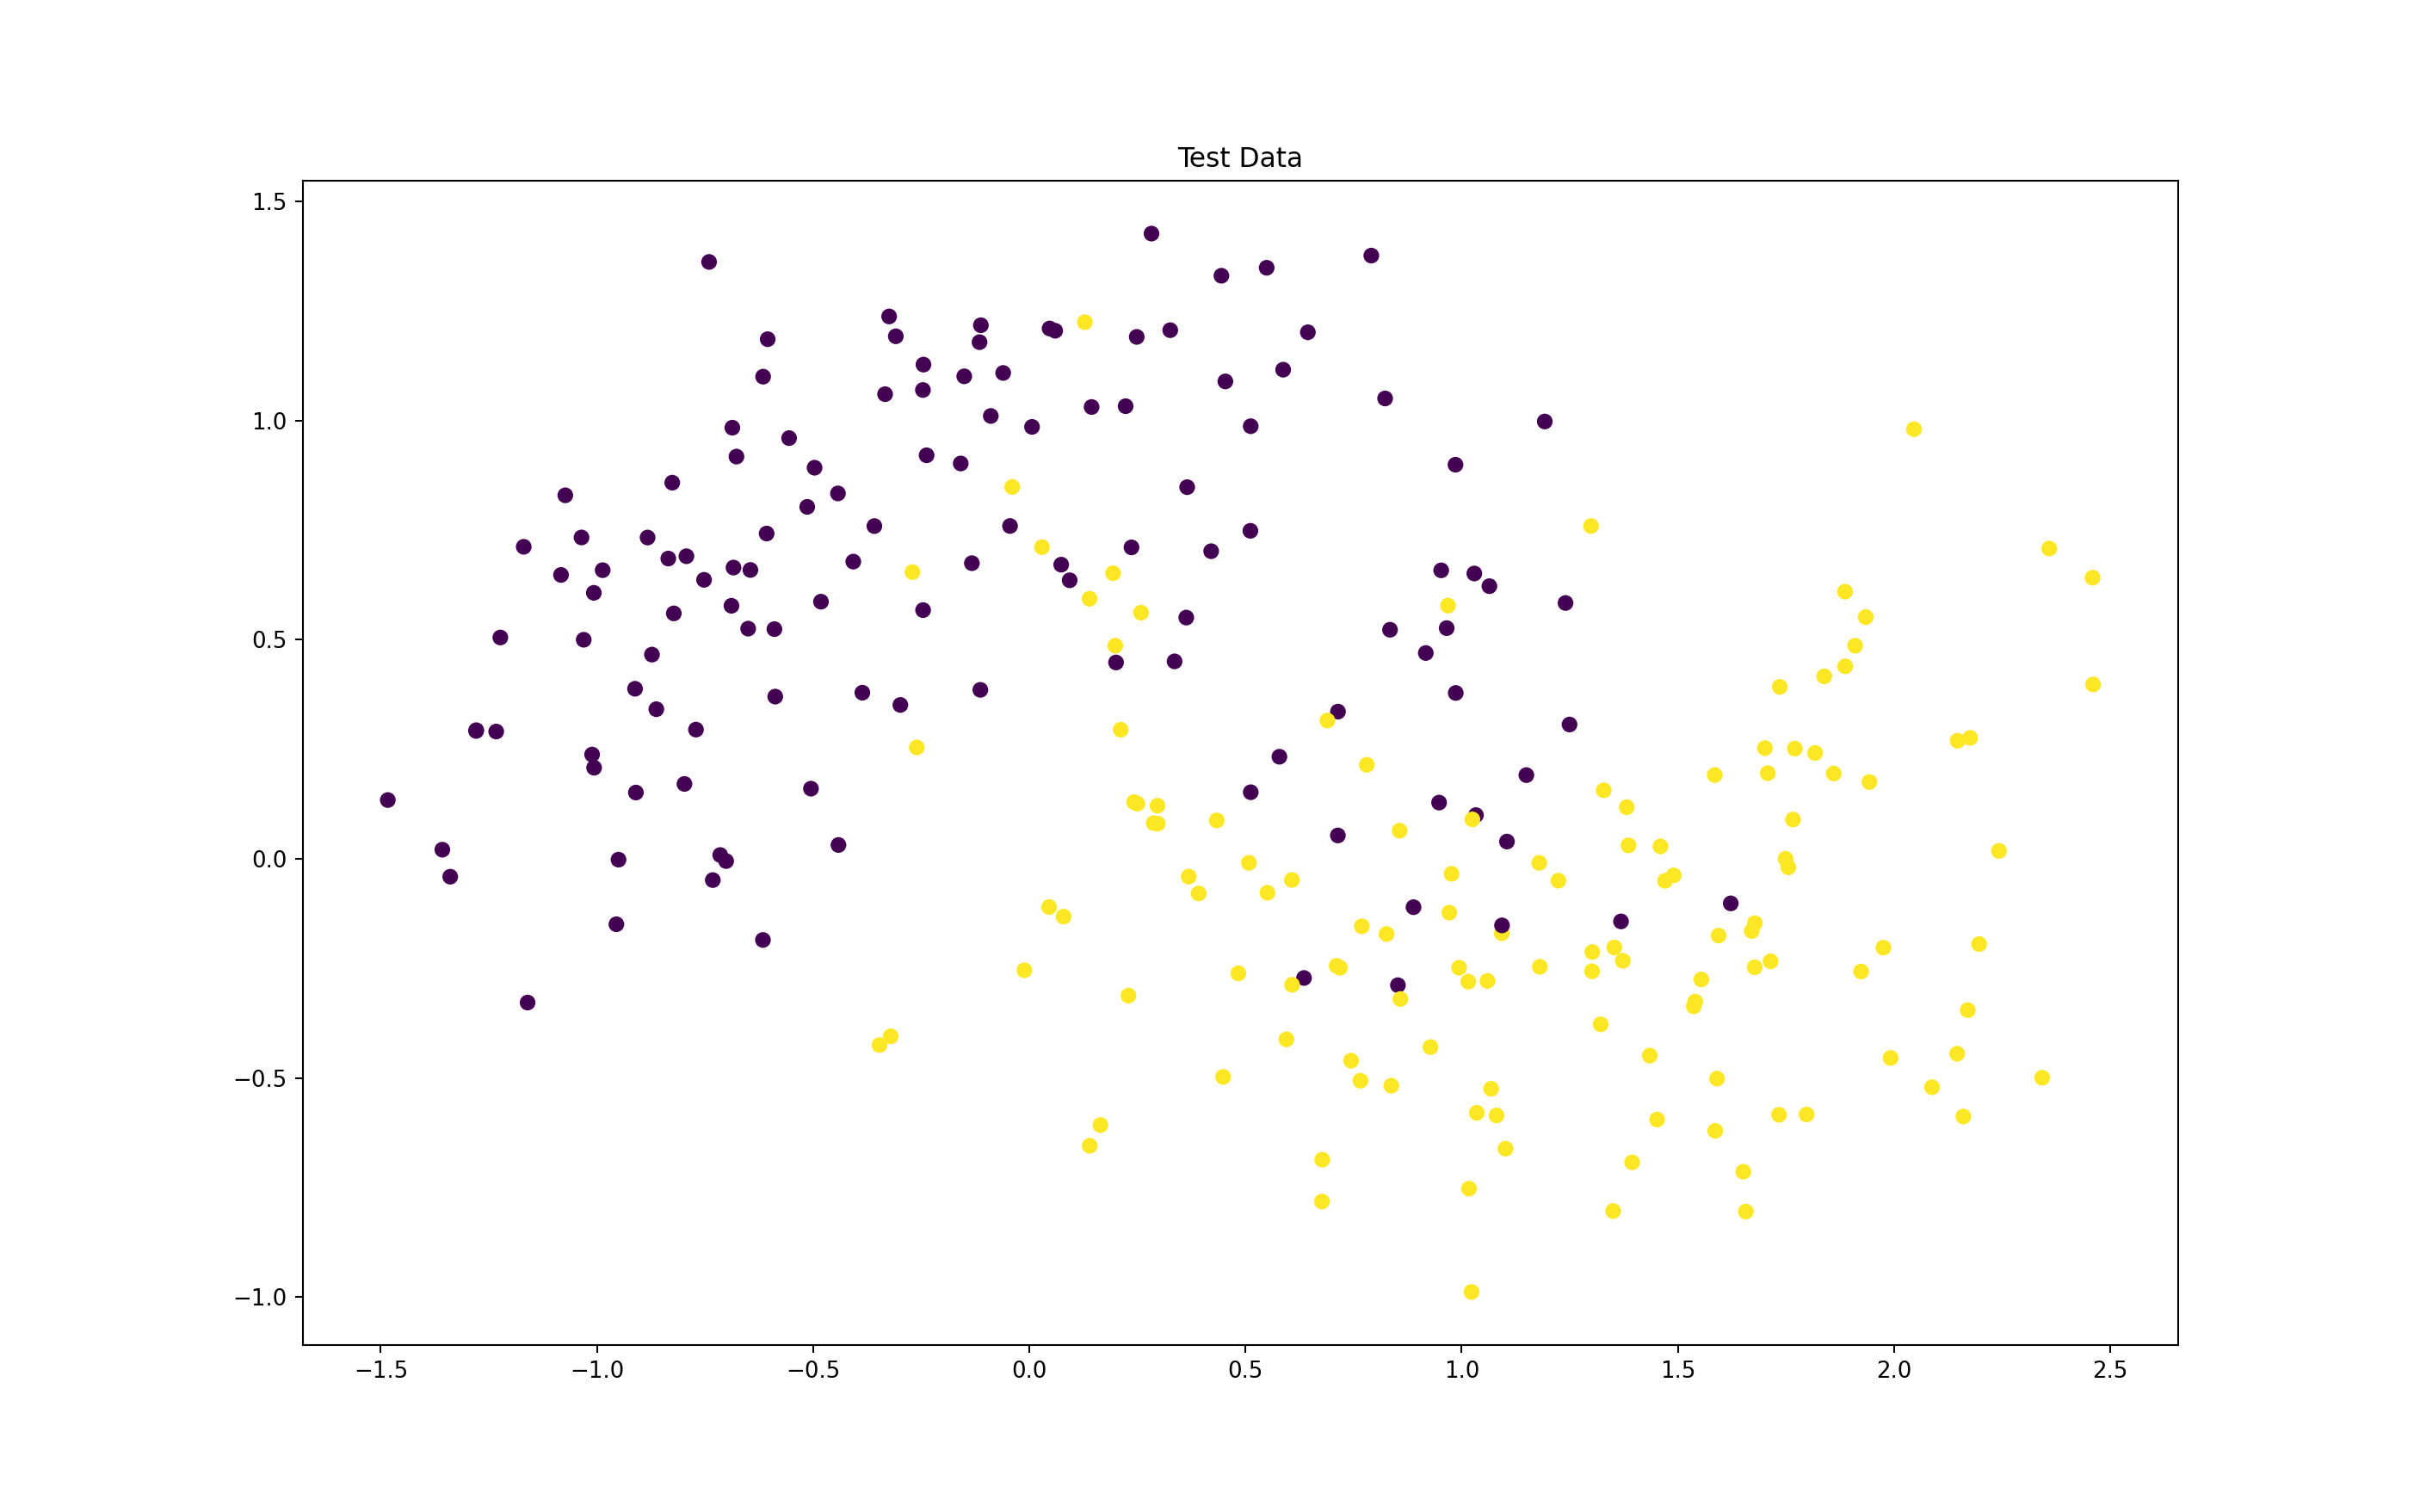

In [54]:
plt.figure(figsize=(8,5))
plt.scatter(X_test[:,0], X_test[:,1], c = Y_test)
plt.title('Test Data')
plt.show()

In [55]:
%%time
moon_scikit_clf_fit_score(X_train, Y_train, X_test, Y_test, 2)

Logistic Regression: 0.884
Decision Tree Classifier: 0.868
Linear SVC: 0.884
KNN Classifier: 0.888
Random Forest Classifier: 0.896
Gradient Boosting Classfier: 0.896
Wall time: 385 ms


In [56]:
%%time
moon_keras_nn_fit_score(X_train, Y_train, X_test, Y_test, 2)

Epoch 1/50
24/24 [==============================] - 0s 1ms/step - loss: 0.7005 - binary_accuracy: 0.5533
Epoch 2/50
24/24 [==============================] - 0s 895us/step - loss: 0.5925 - binary_accuracy: 0.8160
Epoch 3/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4963 - binary_accuracy: 0.8413
Epoch 4/50
24/24 [==============================] - 0s 890us/step - loss: 0.4191 - binary_accuracy: 0.8387
Epoch 5/50
24/24 [==============================] - 0s 1ms/step - loss: 0.3738 - binary_accuracy: 0.8360
Epoch 6/50
24/24 [==============================] - 0s 915us/step - loss: 0.3516 - binary_accuracy: 0.8453
Epoch 7/50
24/24 [==============================] - 0s 956us/step - loss: 0.3402 - binary_accuracy: 0.8453
Epoch 8/50
24/24 [==============================] - 0s 1ms/step - loss: 0.3336 - binary_accuracy: 0.8467
Epoch 9/50
24/24 [==============================] - 0s 1ms/step - loss: 0.3276 - binary_accuracy: 0.8453
Epoch 10/50
24/24 [============================

In [57]:
%%time
moon_pytorch_nn_fit_score(X_train, Y_train, X_test, Y_test, 2)

PyTorch model training...
Epoch: 1, training loss: 0.4079092650910219
Epoch: 2, training loss: 0.29483040067541877
Epoch: 3, training loss: 0.2687209501136434
Epoch: 4, training loss: 0.2521460346331187
Epoch: 5, training loss: 0.24283265977657598
Epoch: 6, training loss: 0.23759305038340311
Epoch: 7, training loss: 0.23487021928654958
Epoch: 8, training loss: 0.23293124470679877
Epoch: 9, training loss: 0.23179763486178073
Epoch: 10, training loss: 0.23151955741461158
Epoch: 11, training loss: 0.2306235421720321
Epoch: 12, training loss: 0.23028596426137302
Epoch: 13, training loss: 0.22991597136946015
Epoch: 14, training loss: 0.22935144904330051
Epoch: 15, training loss: 0.22885390332925515
Epoch: 16, training loss: 0.22800263426681006
Epoch: 17, training loss: 0.22752390583916227
Epoch: 18, training loss: 0.22707449717670958
Epoch: 19, training loss: 0.22646510152005556
Epoch: 20, training loss: 0.22630560951852147
Epoch: 21, training loss: 0.22583722787879928
Epoch: 22, training l

In [58]:
moon_accuracy_df

Dataset 1 Dataset 2 Dataset 3 Dataset 4
Logistic Regression              0.88     0.884       NaN       NaN
Decision Tree Classifier        0.992     0.868       NaN       NaN
Linear SVC                       0.88     0.884       NaN       NaN
KNN Classifier                  0.996     0.888       NaN       NaN
Random Forest Classifier        0.988     0.896       NaN       NaN
Gradient Boosting Classfier     0.992     0.896       NaN       NaN
Keras NN                        0.992     0.896       NaN       NaN
PyTorch NN                          1     0.892       NaN       NaN

In [59]:
moon_X_3, moon_Y_3 = make_moons(1000, noise = 0.5, random_state=47)
X_train, X_test, Y_train, Y_test = train_test_split(moon_X_3, moon_Y_3, 
                                                    test_size = 0.25, random_state = 47)

<IPython.core.display.Javascript object>


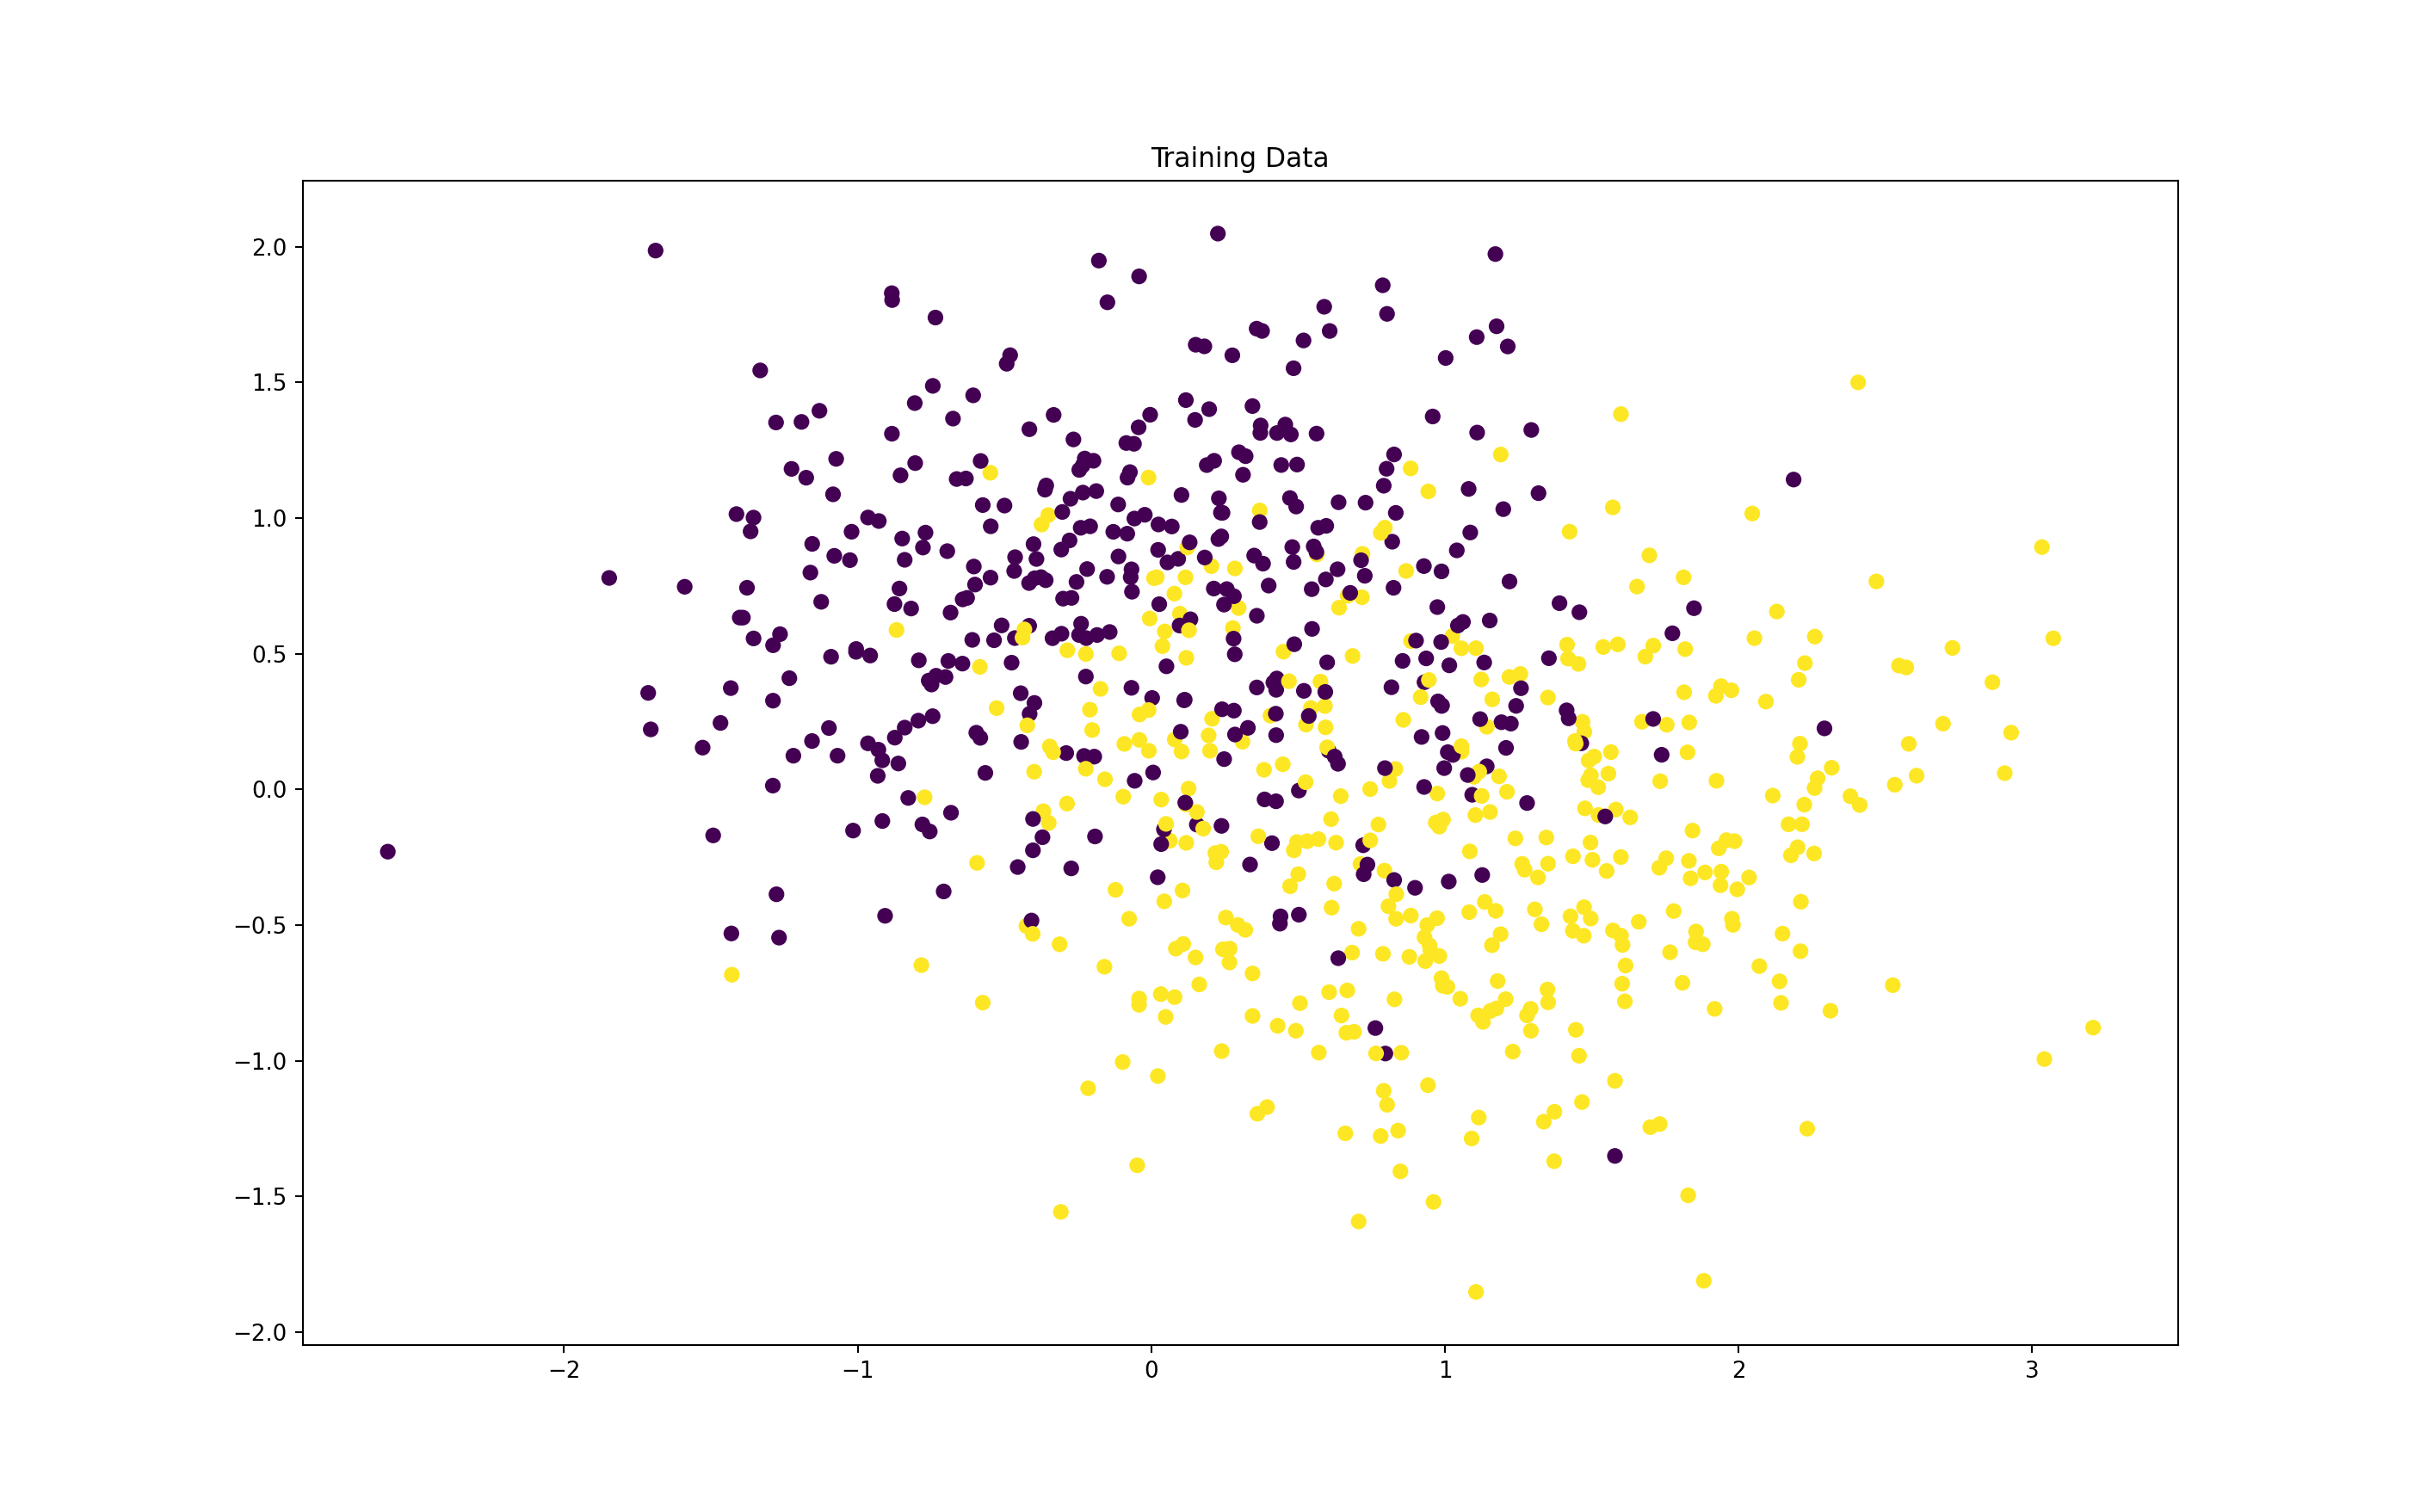

In [60]:
plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], X_train[:,1], c = Y_train)
plt.title('Training Data')
plt.show()

<IPython.core.display.Javascript object>


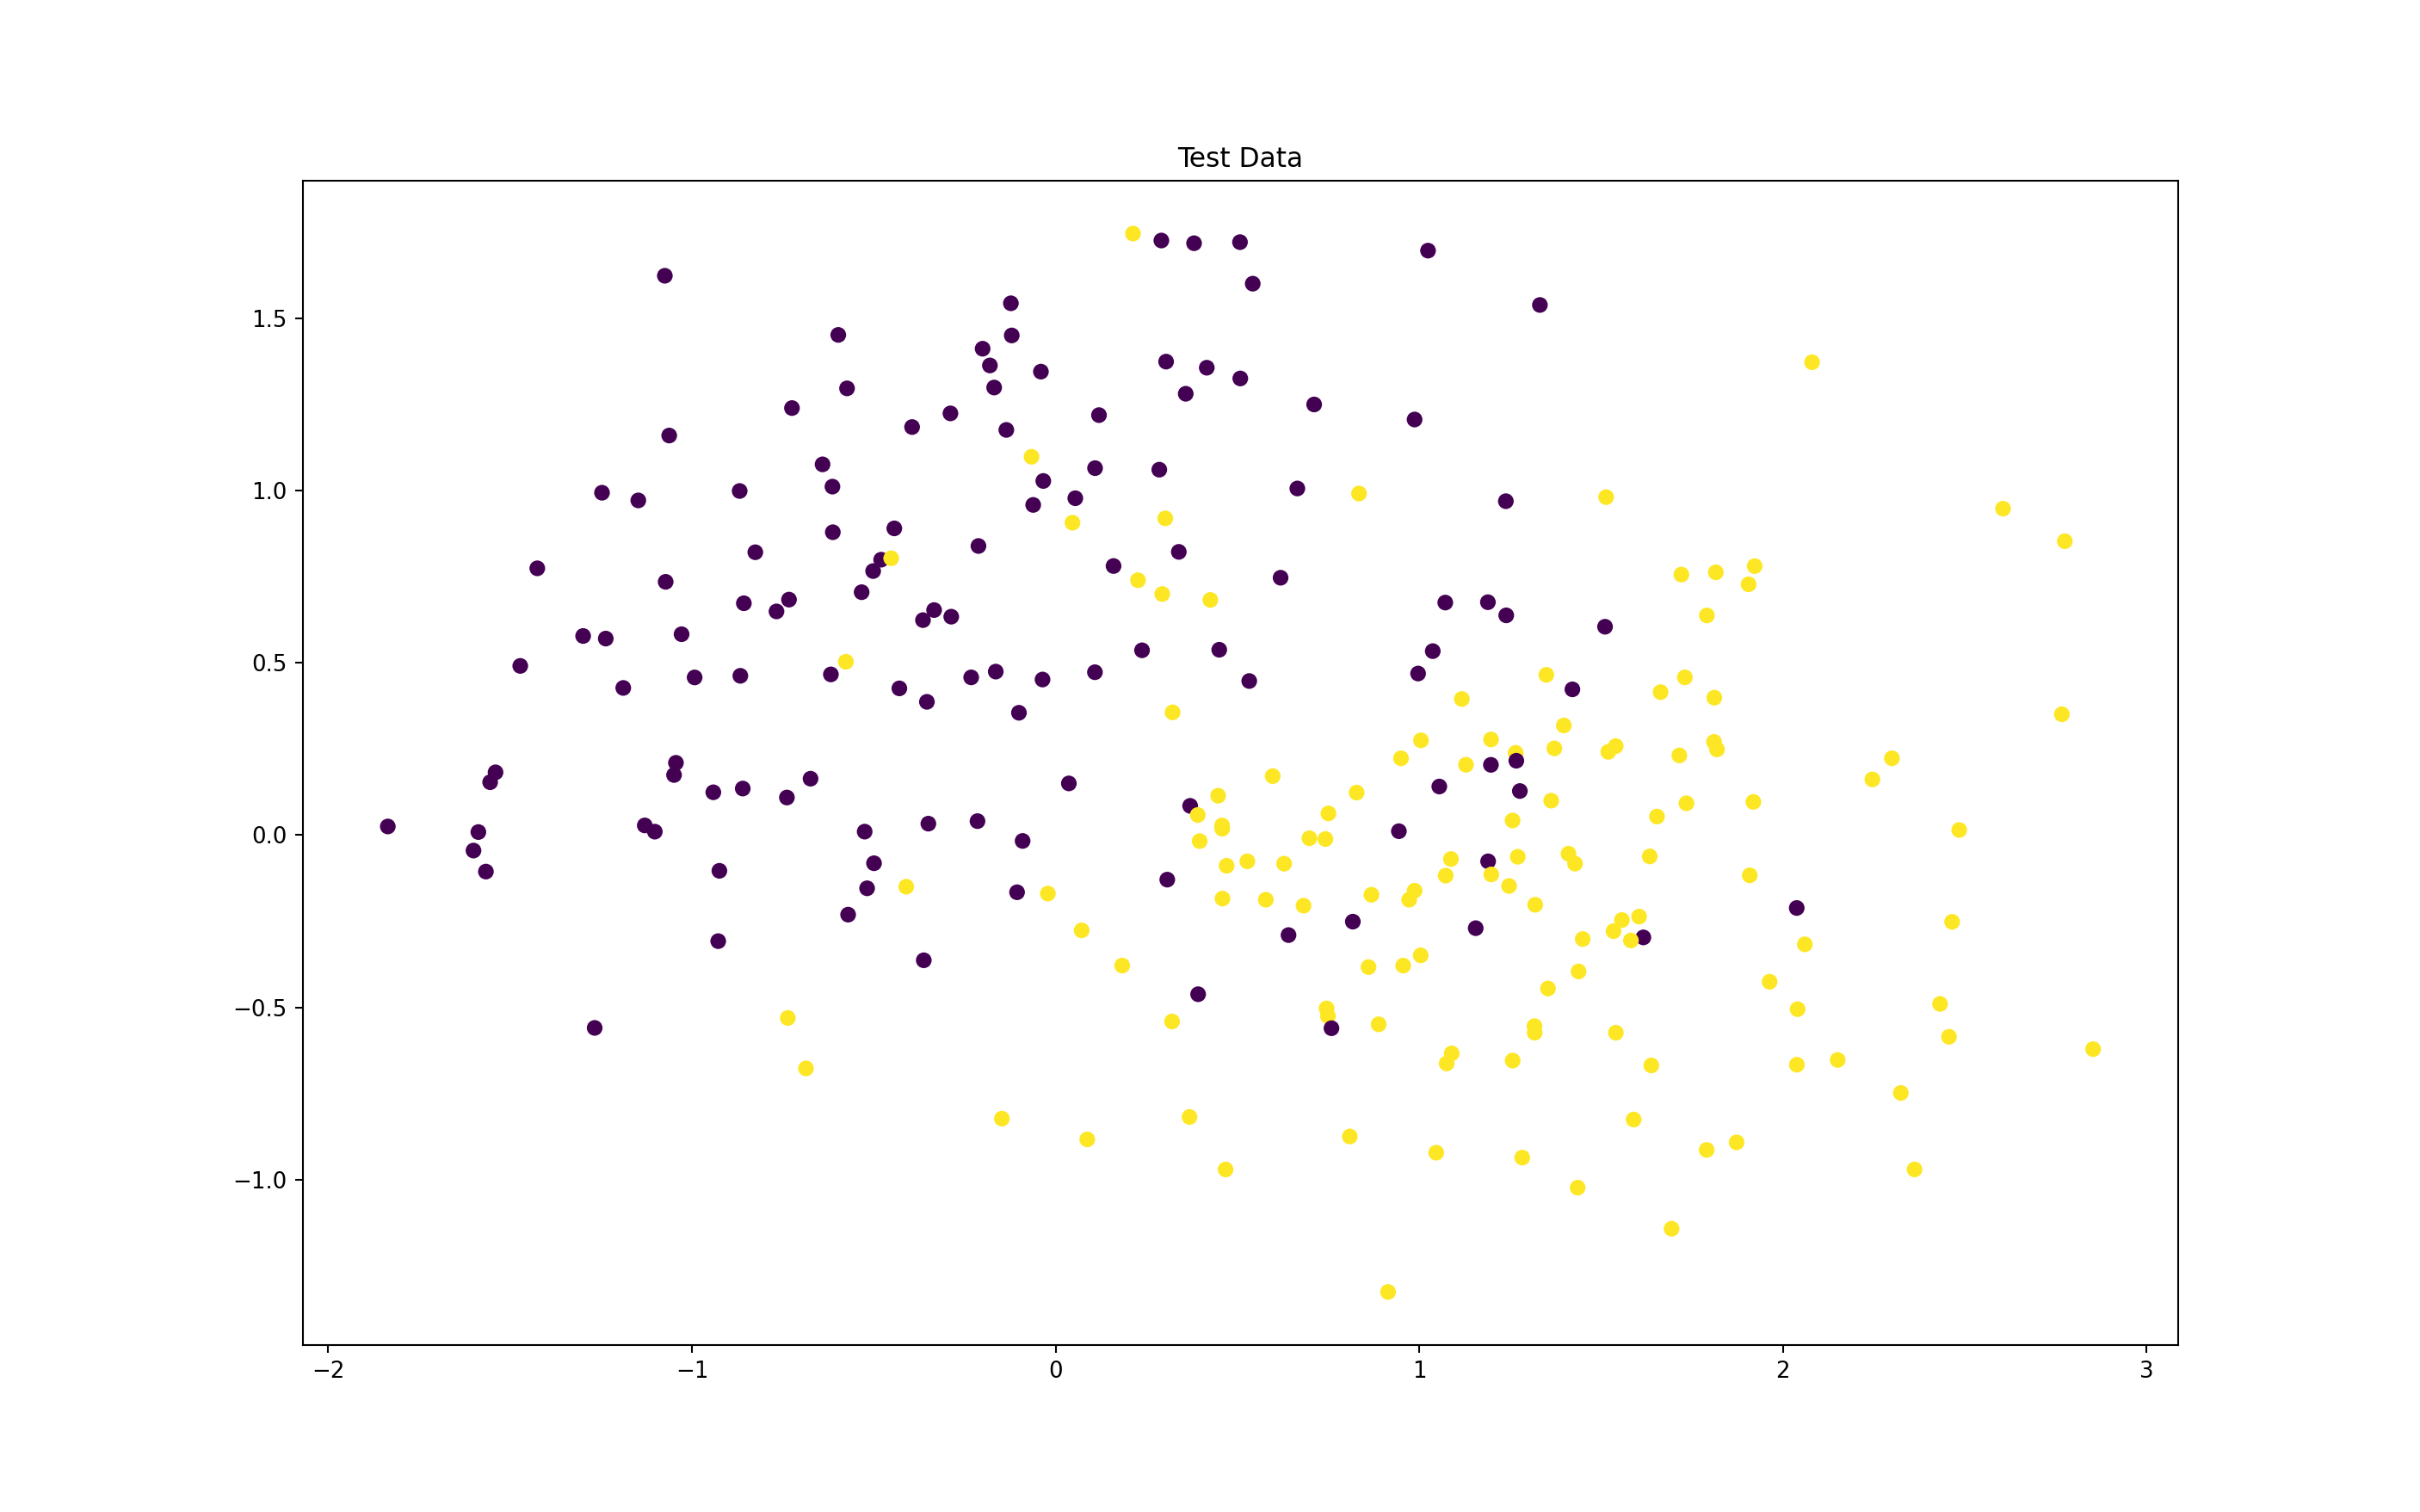

In [61]:
plt.figure(figsize=(8,5))
plt.scatter(X_test[:,0], X_test[:,1], c = Y_test)
plt.title('Test Data')
plt.show()

In [62]:
%%time
moon_scikit_clf_fit_score(X_train, Y_train, X_test, Y_test, 3)

Logistic Regression: 0.852
Decision Tree Classifier: 0.756
Linear SVC: 0.856
KNN Classifier: 0.828
Random Forest Classifier: 0.816
Gradient Boosting Classfier: 0.816
Wall time: 378 ms


In [63]:
%%time
moon_keras_nn_fit_score(X_train, Y_train, X_test, Y_test, 3)

Epoch 1/50
24/24 [==============================] - 0s 1ms/step - loss: 0.6233 - binary_accuracy: 0.8027
Epoch 2/50
24/24 [==============================] - 0s 324us/step - loss: 0.5300 - binary_accuracy: 0.7947
Epoch 3/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4665 - binary_accuracy: 0.7907
Epoch 4/50
24/24 [==============================] - 0s 998us/step - loss: 0.4373 - binary_accuracy: 0.7960
Epoch 5/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4252 - binary_accuracy: 0.7960
Epoch 6/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4229 - binary_accuracy: 0.7987
Epoch 7/50
24/24 [==============================] - 0s 613us/step - loss: 0.4195 - binary_accuracy: 0.7960
Epoch 8/50
24/24 [==============================] - 0s 932us/step - loss: 0.4181 - binary_accuracy: 0.7960
Epoch 9/50
24/24 [==============================] - 0s 972us/step - loss: 0.4167 - binary_accuracy: 0.7933
Epoch 10/50
24/24 [==========================

In [64]:
%%time
moon_pytorch_nn_fit_score(X_train, Y_train, X_test, Y_test, 3)

PyTorch model training...
Epoch: 1, training loss: 0.4712782778882732
Epoch: 2, training loss: 0.415362300646957
Epoch: 3, training loss: 0.409488850807383
Epoch: 4, training loss: 0.40599034349810487
Epoch: 5, training loss: 0.4032360785334604
Epoch: 6, training loss: 0.40111251860754177
Epoch: 7, training loss: 0.39929924272107503
Epoch: 8, training loss: 0.397975698850137
Epoch: 9, training loss: 0.39676779481246677
Epoch: 10, training loss: 0.395906088187757
Epoch: 11, training loss: 0.3951133290967943
Epoch: 12, training loss: 0.39445323221108025
Epoch: 13, training loss: 0.39420460109364164
Epoch: 14, training loss: 0.3935929264436709
Epoch: 15, training loss: 0.3931032777206419
Epoch: 16, training loss: 0.3927112300326747
Epoch: 17, training loss: 0.3923311532109704
Epoch: 18, training loss: 0.391817823558129
Epoch: 19, training loss: 0.39153778560674984
Epoch: 20, training loss: 0.39121532231296685
Epoch: 21, training loss: 0.3909471692996837
Epoch: 22, training loss: 0.3906762

In [65]:
moon_accuracy_df

Dataset 1 Dataset 2 Dataset 3 Dataset 4
Logistic Regression              0.88     0.884     0.852       NaN
Decision Tree Classifier        0.992     0.868     0.756       NaN
Linear SVC                       0.88     0.884     0.856       NaN
KNN Classifier                  0.996     0.888     0.828       NaN
Random Forest Classifier        0.988     0.896     0.816       NaN
Gradient Boosting Classfier     0.992     0.896     0.816       NaN
Keras NN                        0.992     0.896     0.856       NaN
PyTorch NN                          1     0.892      0.82       NaN

In [66]:
moon_X_4, moon_Y_4 = make_moons(1000, noise = 0.7, random_state=47)
X_train, X_test, Y_train, Y_test = train_test_split(moon_X_4, moon_Y_4, 
                                                    test_size = 0.25, random_state = 47)

<IPython.core.display.Javascript object>


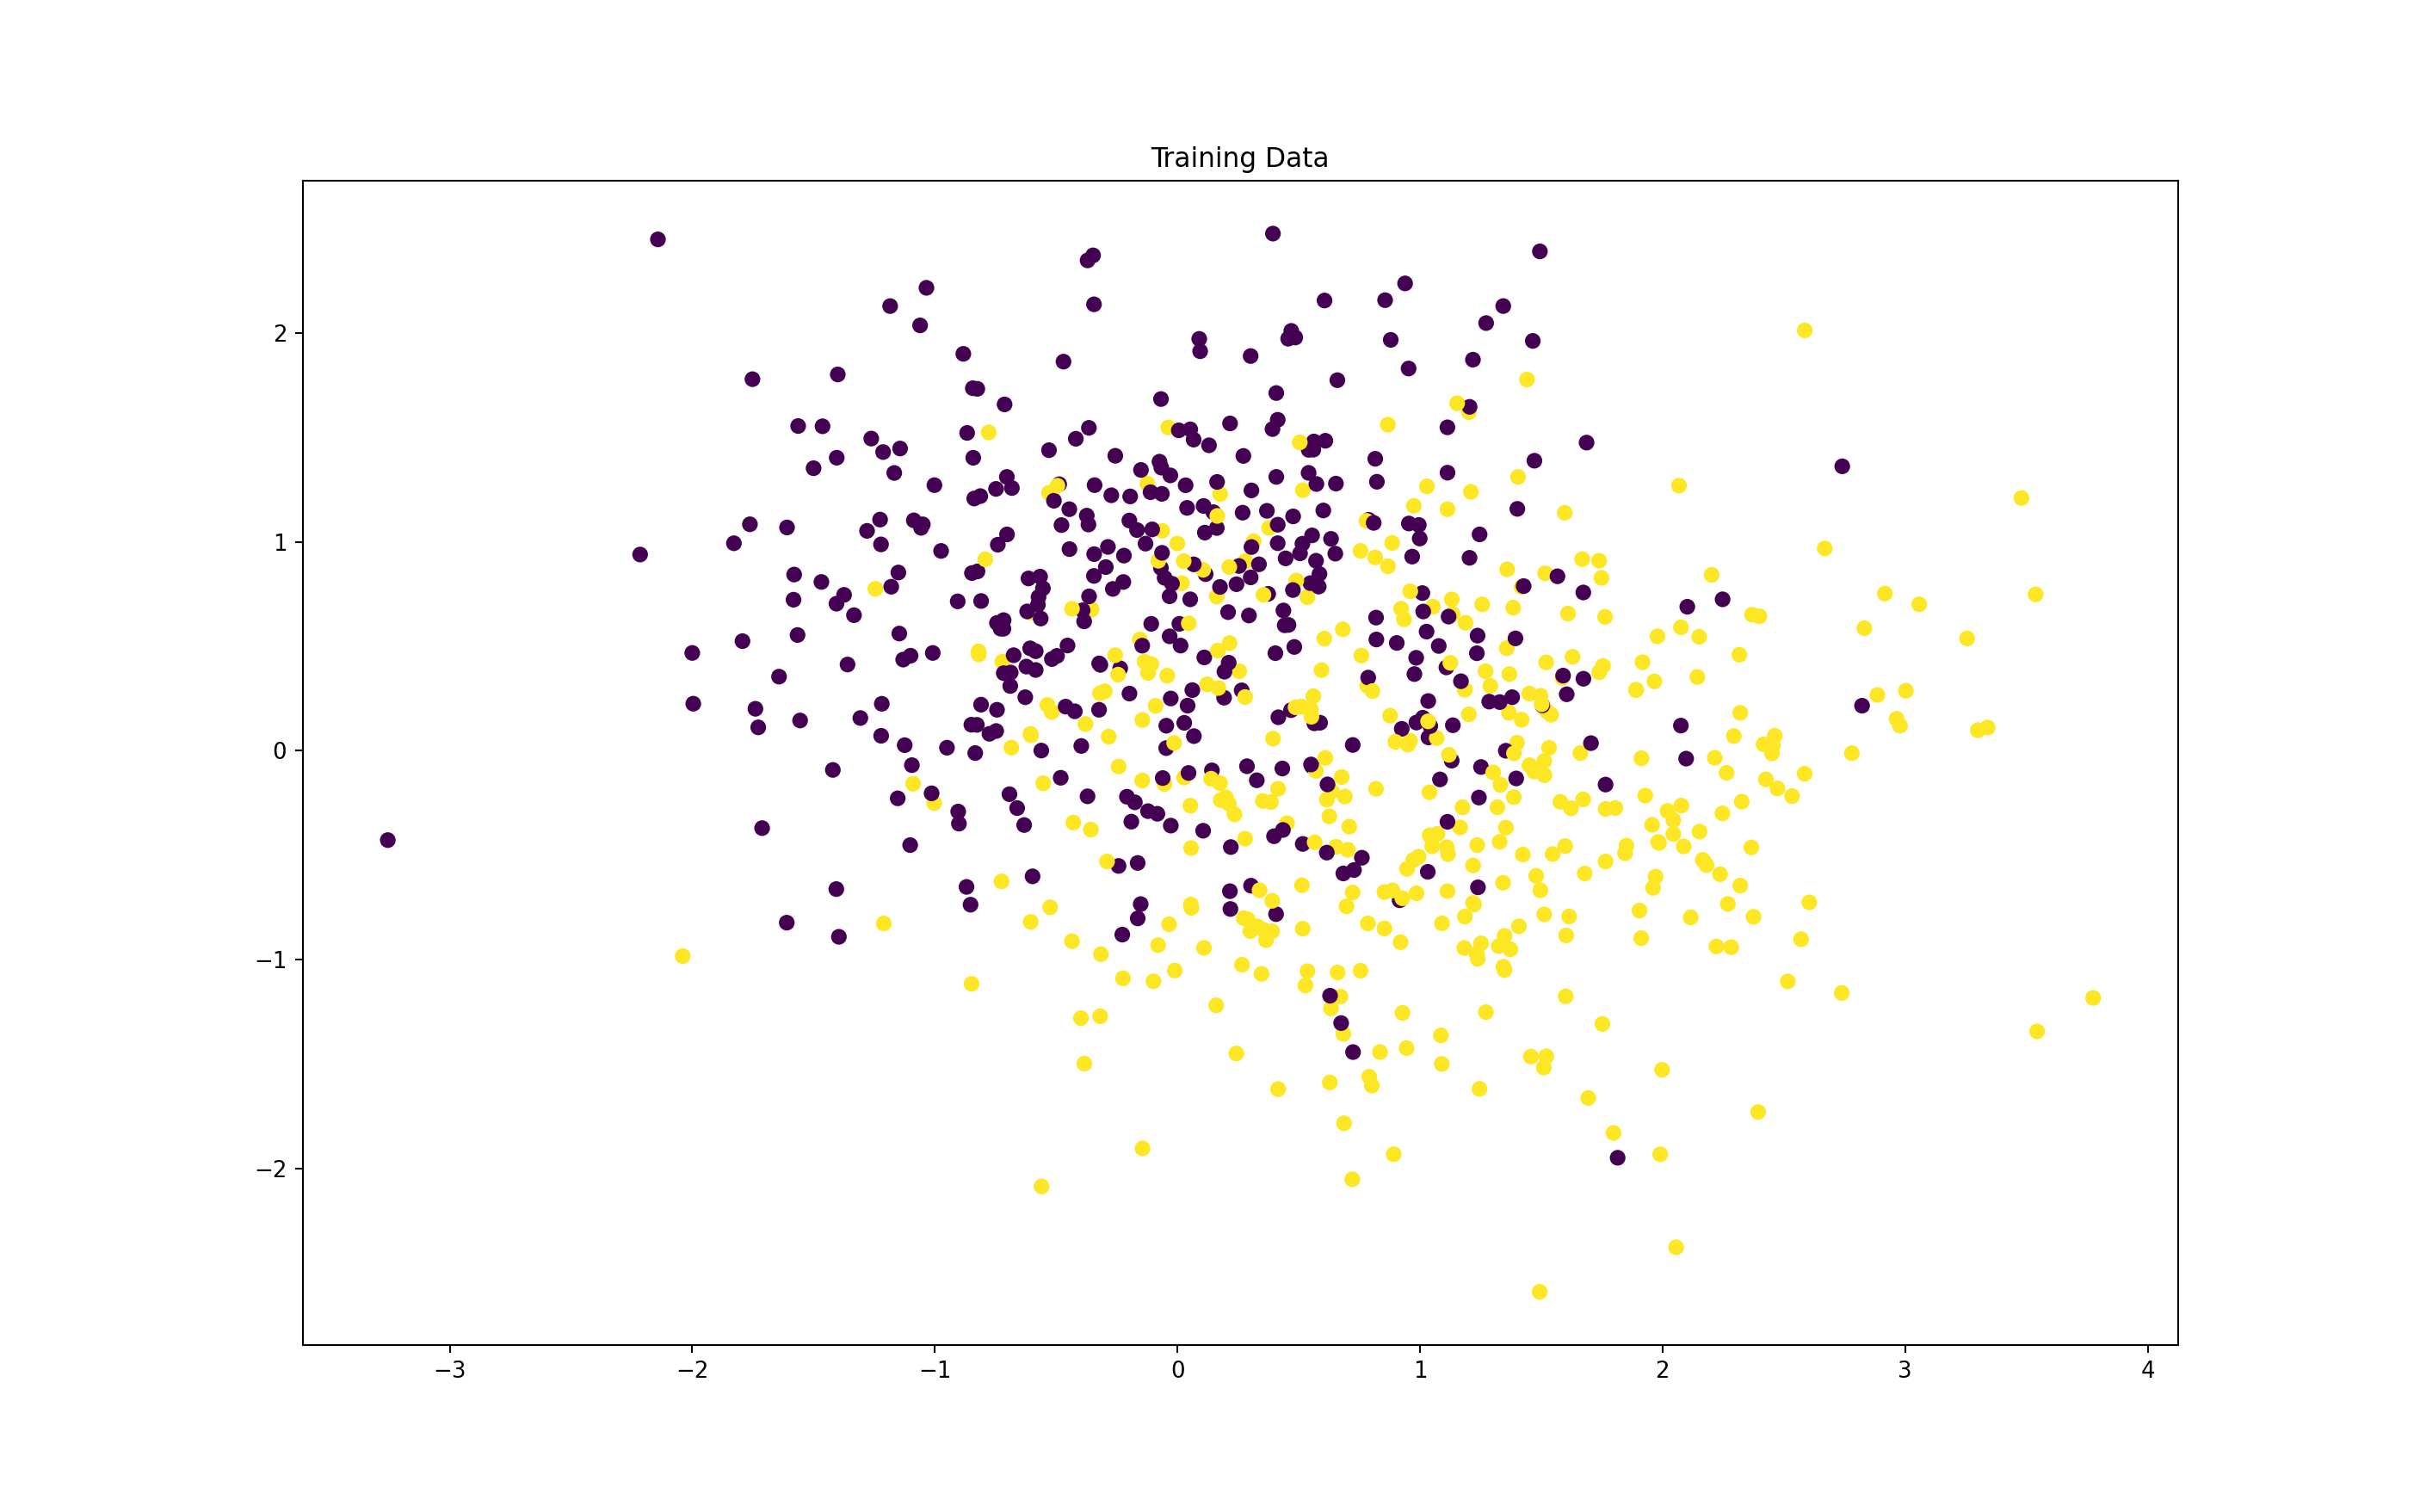

In [67]:
plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], X_train[:,1], c = Y_train)
plt.title('Training Data')
plt.show()

<IPython.core.display.Javascript object>


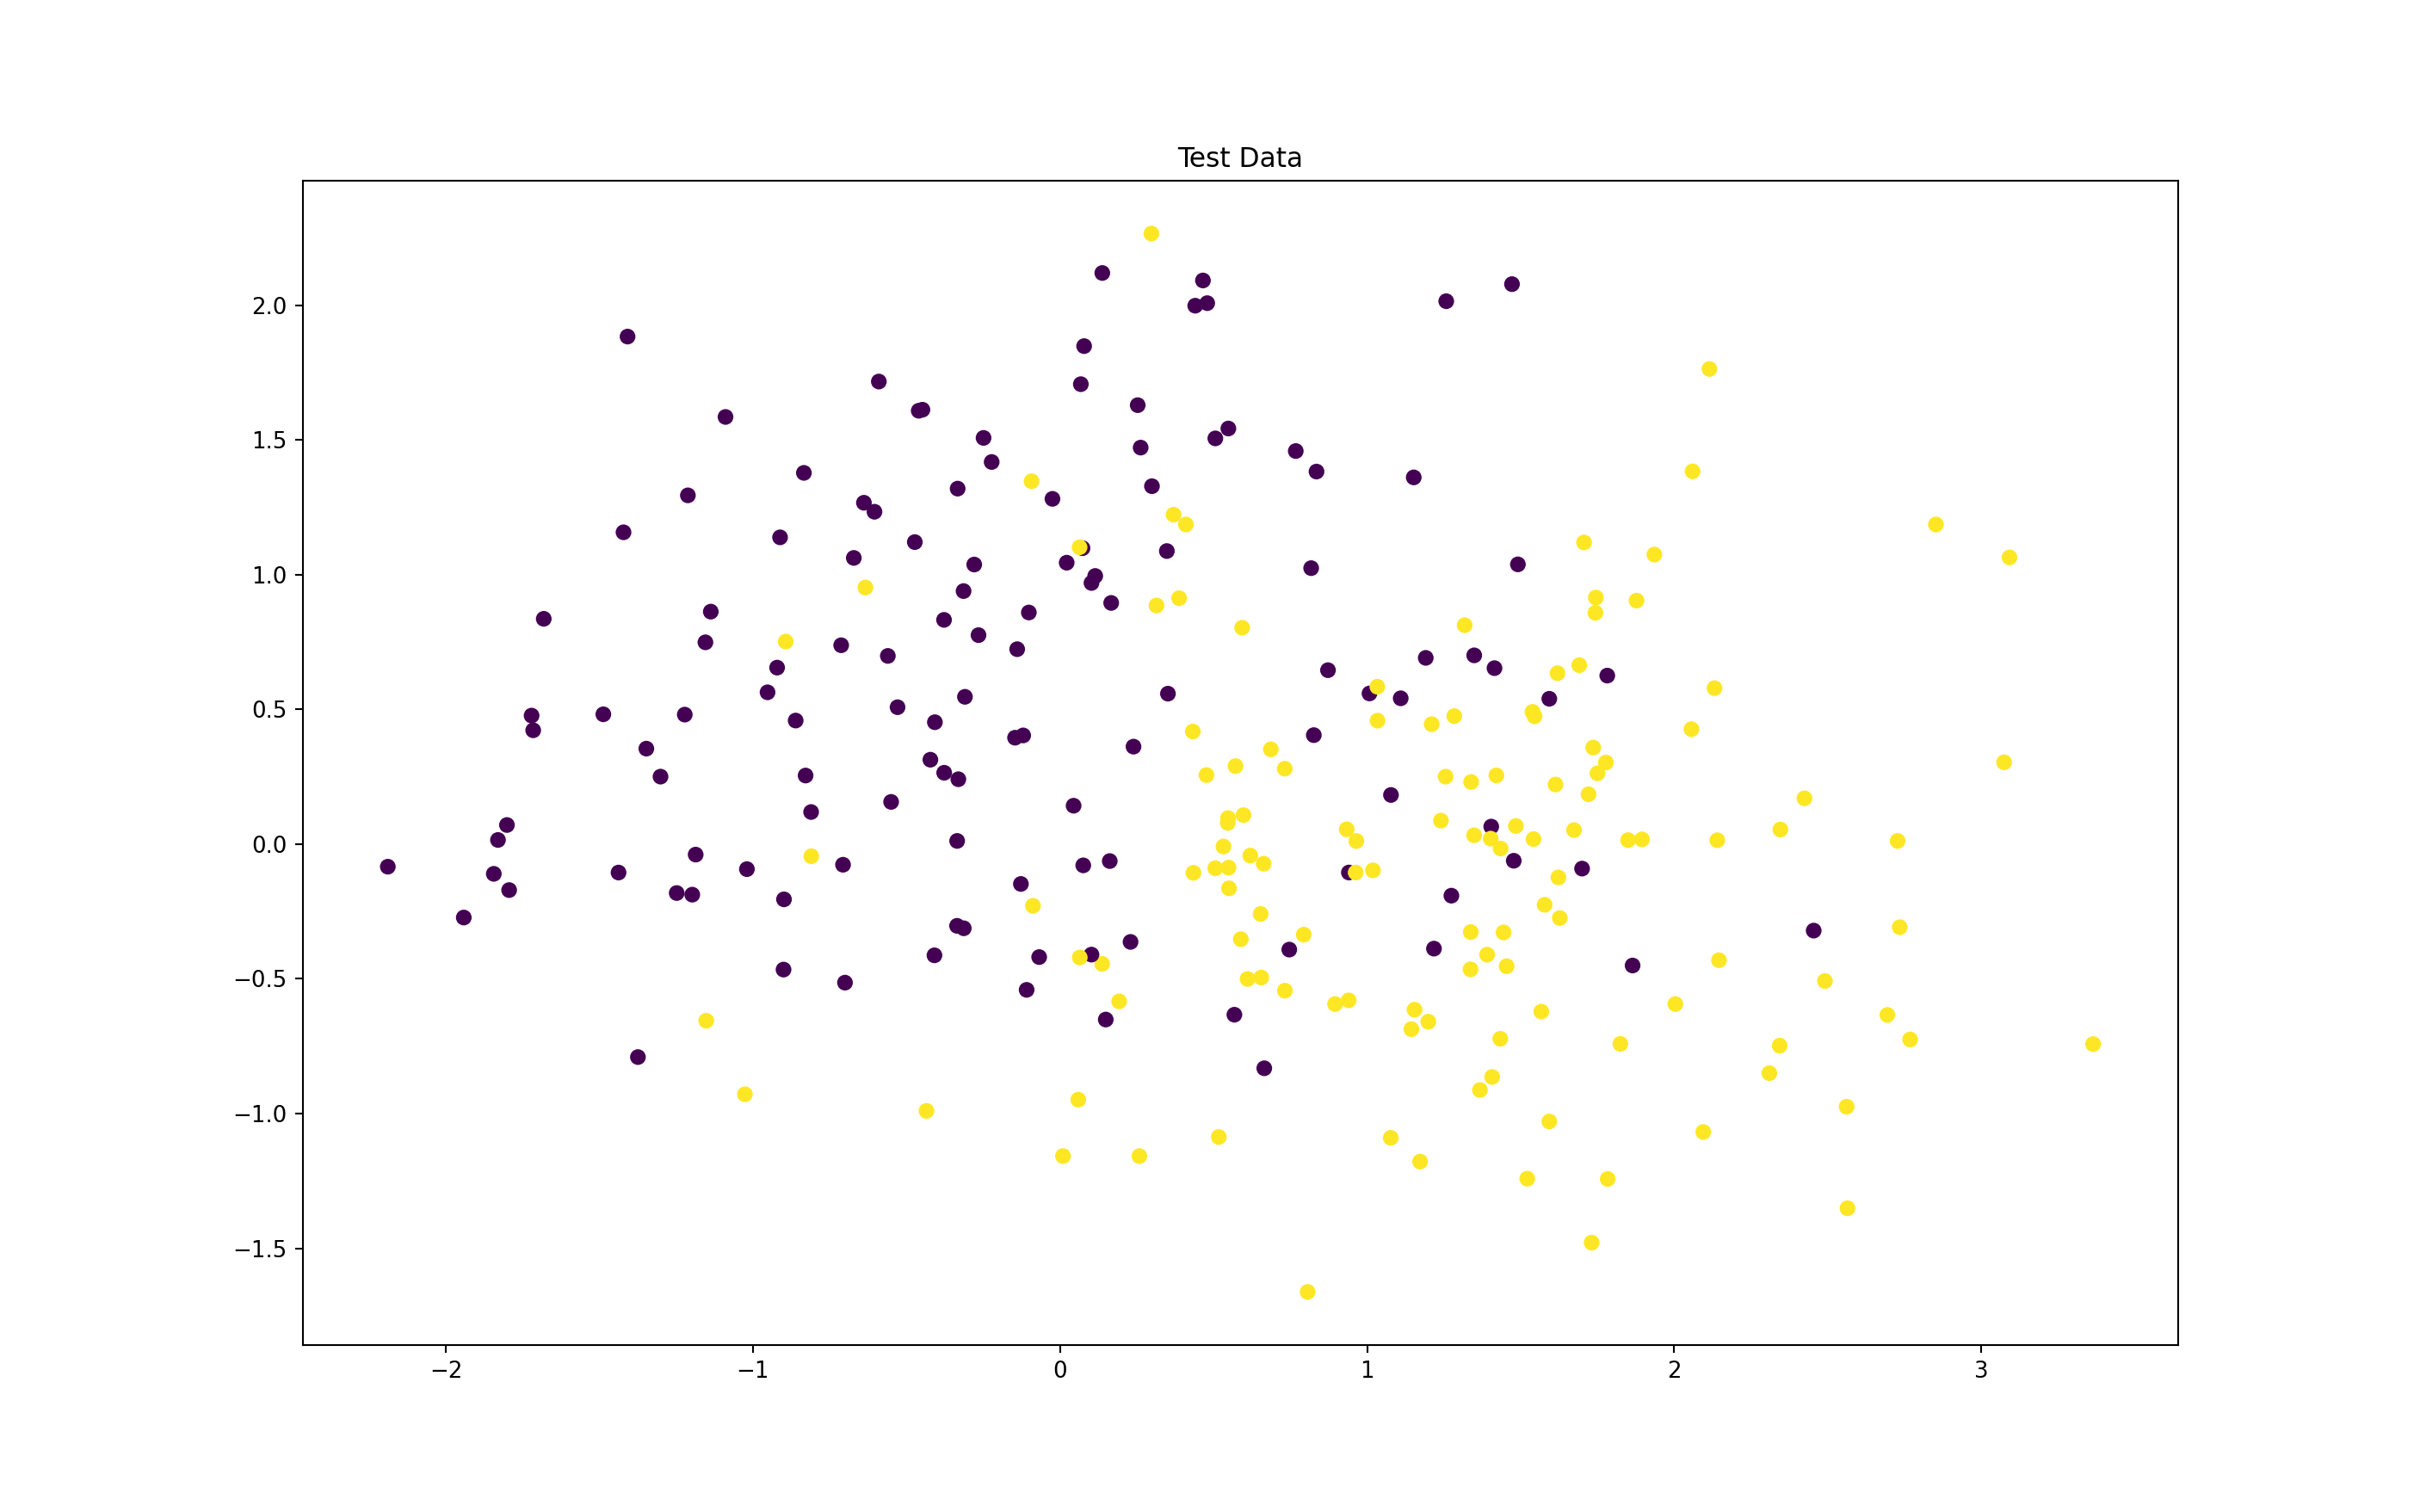

In [68]:
plt.figure(figsize=(8,5))
plt.scatter(X_test[:,0], X_test[:,1], c = Y_test)
plt.title('Test Data')
plt.show()

In [69]:
%%time
moon_scikit_clf_fit_score(X_train, Y_train, X_test, Y_test, 4)

Logistic Regression: 0.828
Decision Tree Classifier: 0.728
Linear SVC: 0.824
KNN Classifier: 0.756
Random Forest Classifier: 0.744
Gradient Boosting Classfier: 0.796
Wall time: 553 ms


In [70]:
%%time
moon_keras_nn_fit_score(X_train, Y_train, X_test, Y_test, 4)

Epoch 1/50
24/24 [==============================] - 0s 292us/step - loss: 0.6587 - binary_accuracy: 0.6253
Epoch 2/50
24/24 [==============================] - 0s 945us/step - loss: 0.5672 - binary_accuracy: 0.7627
Epoch 3/50
24/24 [==============================] - 0s 1ms/step - loss: 0.5144 - binary_accuracy: 0.7613
Epoch 4/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4924 - binary_accuracy: 0.7613
Epoch 5/50
24/24 [==============================] - 0s 501us/step - loss: 0.4847 - binary_accuracy: 0.7667
Epoch 6/50
24/24 [==============================] - 0s 905us/step - loss: 0.4815 - binary_accuracy: 0.7680
Epoch 7/50
24/24 [==============================] - 0s 961us/step - loss: 0.4809 - binary_accuracy: 0.7680
Epoch 8/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4812 - binary_accuracy: 0.7693
Epoch 9/50
24/24 [==============================] - 0s 948us/step - loss: 0.4789 - binary_accuracy: 0.7693
Epoch 10/50
24/24 [========================

In [71]:
%%time
moon_pytorch_nn_fit_score(X_train, Y_train, X_test, Y_test, 4)

PyTorch model training...
Epoch: 1, training loss: 0.5379357514244815
Epoch: 2, training loss: 0.48285155692355086
Epoch: 3, training loss: 0.48080841740515706
Epoch: 4, training loss: 0.47929807486540327
Epoch: 5, training loss: 0.4782147507450233
Epoch: 6, training loss: 0.47747033602666733
Epoch: 7, training loss: 0.4768441520630537
Epoch: 8, training loss: 0.4762851342638023
Epoch: 9, training loss: 0.47590382452704943
Epoch: 10, training loss: 0.47558788674906827
Epoch: 11, training loss: 0.4751805220216435
Epoch: 12, training loss: 0.47491480356637233
Epoch: 13, training loss: 0.47446393318128927
Epoch: 14, training loss: 0.4742034905725935
Epoch: 15, training loss: 0.47408449159450056
Epoch: 16, training loss: 0.4736185697959736
Epoch: 17, training loss: 0.47352373200526926
Epoch: 18, training loss: 0.47327947497259204
Epoch: 19, training loss: 0.473086927942466
Epoch: 20, training loss: 0.4727193286908247
Epoch: 21, training loss: 0.47277506620266163
Epoch: 22, training loss: 0

In [72]:
moon_accuracy_df

Dataset 1 Dataset 2 Dataset 3 Dataset 4
Logistic Regression              0.88     0.884     0.852     0.828
Decision Tree Classifier        0.992     0.868     0.756     0.728
Linear SVC                       0.88     0.884     0.856     0.824
KNN Classifier                  0.996     0.888     0.828     0.756
Random Forest Classifier        0.988     0.896     0.816     0.744
Gradient Boosting Classfier     0.992     0.896     0.816     0.796
Keras NN                        0.992     0.896     0.856     0.828
PyTorch NN                          1     0.892      0.82     0.808

In [52]:
moon_X_5, moon_Y_5 = make_moons(1000, noise = 1, random_state=47)
X_train, X_test, Y_train, Y_test = train_test_split(moon_X_5, moon_Y_5, 
                                                    test_size = 0.25, random_state = 47)

Looking at the accuracy values across the moon datasets, the two neural networks performed consistently well in comparison to the other algorithms. Also, Logistic Regression and Linear SVC did surprisingly well considering the datasets are not linearly separable, and the decision boundaries for both algorithms are linear.  

Looking at the training sets, we can see that they are somewhat linearly separable, or at least there are visible boundaries that minize the number of misclassifications for both classes. That explains why Logistic Regression and Linear SVC did so well.